In [121]:
import sys
sys.path.append('../..')  # Expose top level program access

import re
import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from utils import tools, callbacks, metrics, supported_preprocessing_transforms
from modules.cae_base_module import CAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.vae_base_module import VAEBaseModule
from datasets import supported_datamodules
from models import supported_models
from functools import reduce

# Novel Region Extraction with Generic Reconstructions

Images of planetary landscapes contain incredible amounts of valuable information. This poses a problem for novelty detection. Since truly novel content may only take up a small fraction of the image, global image properties that may be useful for novelty detection are diluated by the other details in the landscape. This experiment seeks to address this limitation by implementing *novel region extraction*, the task of tagging regions in larger images and ranking them by novelty. We hypothesize that by using unsupervised object recognition to intelligently cropped regions, general reconstruction-based detection techniques can be repurposed into novel region extractors.

From a practical perspective, the region proposal step is implemented within the preprocessing pipeline. In the following code, the region proposal itself is called implicitly in the `supported_preprocessing_transforms`, the code for it is found in `utils/preprocessing.py`. Given the large computational burden placed on the CPU when region extraction  is used during preprocessing, it is easier to load the batch once and test each model serially than to test the models with their own dedicted dataloaders. One downside is that the batch size is static for all testing cycles; however, since batches are looped over in the `test_step` regardless of the model, this only affects the amount of data dropped in the final batch when the test size isn't divisible by the batch size.

In [10]:
# Import configurations and paths to logged models
root = Path.cwd() / '..' / '..'
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models_ss = list(Path(log_path).glob('**/archive_nre*'))
paths_to_archived_models_bing = list(Path(log_path).glob('**/archive_bing*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in (*paths_to_archived_models_ss, *paths_to_archived_models_bing)]))

Found archived models:
------
SimpleVAE/archive_nre1_2021-05-04
SimpleVAE/archive_nre2_2021-05-04
BaselineCAE/archive_nre1_2021-05-02
CompressionCAEHighCapacity/archive_nre1_2021-05-03
CompressionCAEMidCapacity/archive_nre1_2021-05-02
BaselineAAE/archive_nre1_2021-05-07
BaselineVAE/archive_bing1_2021-05-20
BaselineCAE/archive_bing1_2021-05-19
BaselineAAE/archive_bing1_2021-05-19


In [11]:
from experiments.helpers import load_modules

module_catalog_ss, datamodule_ss, _ = load_modules(paths_to_archived_models_ss)
module_catalog_bing, datamodule_bing, _ = load_modules(paths_to_archived_models_bing)

Loading state dict for: SimpleVAE/archive_nre1_2021-05-04
Loading state dict for: SimpleVAE/archive_nre2_2021-05-04
Loading state dict for: BaselineCAE/archive_nre1_2021-05-02
Loading state dict for: CompressionCAEHighCapacity/archive_nre1_2021-05-03
Loading state dict for: CompressionCAEMidCapacity/archive_nre1_2021-05-02
Loading state dict for: BaselineAAE/archive_nre1_2021-05-07
Loading state dict for: BaselineVAE/archive_bing1_2021-05-20
Loading state dict for: BaselineCAE/archive_bing1_2021-05-19
Loading state dict for: BaselineAAE/archive_bing1_2021-05-19


In [16]:
def rp_test_modules(datamodule, module_catalog):
    for batch_nb, batch in enumerate(datamodule.test_dataloader()):
        print(f'------\nLoaded batch {batch_nb}\n------')
                
        # Extract the model type (e.g. CAE, AAE, VAE) and their versions
        for model_type, model_versions in module_catalog.items():
            
            # Extract the name of the archive and the module's state dict
            for model_name, module in model_versions.items():
                
                # Set the model/components in evaluation mode
                if 'AAE' in model_type:
                    module.encoder.eval()
                    module.decoder.eval()
                else:
                    module.model.eval()
                
                short_name = model_type + '-' + model_name.split('_')[1]
                if short_name not in result_catalog:
                    result_catalog[short_name] = {
                        'scores': [], 
                        'filepaths': [],
                        'gt_bboxes': [],
                        'cr_bboxes': []
                    }
                print(f'Testing on: {short_name}')

                result = module.test_step(batch, batch_nb)
                
                result_catalog[short_name]['scores'].extend(result['scores'])
                result_catalog[short_name]['filepaths'].extend(result['labels']['filepaths'])
                result_catalog[short_name]['gt_bboxes'].extend(result['labels']['gt_bboxes'])
                result_catalog[short_name]['cr_bboxes'].extend(result['labels']['cr_bboxes'])
    return result_catalog
    
# Testing loop
# Caution: this loop takes _minutes_ to run.
start = time.time()

# Collect scores and labels for all models in a catalog
result_catalog = {}

# Loop over the test dataloader, using the same batch for each model to save time
with torch.no_grad():
    result_catalog_ss = rp_test_modules(datamodule_ss, module_catalog_ss)
    result_catalog_bing = rp_test_modules(datamodule_bing, module_catalog_bing)
                
print(f'Testing took: {time.time() - start:.2f}')

------
Loaded batch 0
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 1
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 2
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 3
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testing on: BaselineCAE-nre1
Testing on: CompressionCAEHighCapacity-nre1
Testing on: CompressionCAEMidCapacity-nre1
Testing on: BaselineAAE-nre1
------
Loaded batch 4
------
Testing on: SimpleVAE-nre1
Testing on: SimpleVAE-nre2
Testi

------
Loaded batch 19
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 20
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 21
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 22
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 23
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 24
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
------
Loaded batch 25
------
Testing on: BaselineVAE-bing1
Testing on: BaselineCAE-bing1
Testing on: BaselineAAE-bing1
Testing took: 1597.46


In [177]:
# Merge the bing and ss results, but dataloaders are still seperate
result_catalog = {**result_catalog_ss, **result_catalog_bing}

# Format data for plotting and analysis
for sn, results in result_catalog.items():
    results['scores'] = np.array(results['scores'])
    results['filepaths'] = np.array(results['filepaths']).reshape(-1)
    results['gt_bboxes'] = np.array(results['gt_bboxes']).reshape(-1, 4)
    results['cr_bboxes'] = np.array(results['cr_bboxes']).reshape(-1, 4)
    print(f'[{sn}]\t Predicted {results["scores"].shape} scores, '\
          f'with {results["gt_bboxes"].shape} gt boxes, and {results["cr_bboxes"].shape} rps')

with open('nre-results_2021-05-05.pkl', 'wb') as f:
    pickle.dump(result_catalog, f)

[SimpleVAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[SimpleVAE-nre2]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineCAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[CompressionCAEHighCapacity-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[CompressionCAEMidCapacity-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineAAE-nre1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineVAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineCAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps
[BaselineAAE-bing1]	 Predicted (13312,) scores, with (13312, 4) gt boxes, and (13312, 4) rps


In [178]:
# Checkout the preprocessing transforms that were applied to the datamodules
print('Selective Search approach: ', datamodule_ss._data_transforms)
print('Saliency approach: ', datamodule_bing._data_transforms)

Selective Search approach:  Compose(
)
Saliency approach:  Compose(
)


# Region Proposal Analysis

In [211]:
%matplotlib inline

# For now, just run the analysis on all of the models
iou_results = {}

for sn, res in result_catalog.items():
    ious = []
    # binary_labels = []  # IOU > 0.5 counts as a label
    n_duplicates = 0
    n_novelties = 428
    iou_thresh = 0.5

    gt_bboxes = res['gt_bboxes']
    cr_bboxes = res['cr_bboxes']
    for i, (gt, cr) in enumerate(zip(gt_bboxes, cr_bboxes)):
        cr = cr * 5  # Rescale the bounding boxes, see 'scale' parameter in LunarAnaloguePreprocesing
        iou = metrics.iou(cr, gt)
        ious.append(iou)

        if i == 0:
            prev_gt = [-1, -1, -1, -1]
        if iou > iou_thresh:
            if all(gt == prev_gt):
                n_duplicates += 1
            prev_gt = gt
            
        if iou > iou_thresh and ('CAE-bing' in sn or 'CAE-nre' in sn):
            im = plt.imread((res['filepaths'][i]))
            fig, ax = plt.subplots()
            ax.imshow(im)
            gt_rect = patches.Rectangle((gt[0], gt[1]), gt[2], gt[3], edgecolor='C0', facecolor='none', lw=3)
            cr_rect = patches.Rectangle((cr[0], cr[1]), cr[2], cr[3], edgecolor='C1', facecolor='none', lw=3)
            ax.add_patch(gt_rect)
            ax.add_patch(cr_rect)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.savefig(f'overlaps-from-datamodule/GoodIOU-{sn}-iou={int(iou*100)}.png', bbox_inches='tight')
            plt.close()
            

    ious = np.array(ious)
    bin_labels = ious > iou_thresh
    
    print(f'------\n{sn}\n------')
    print(f'N labels: {sum(bin_labels)}')
    print(f'N duplicates: {n_duplicates}')
    print(f'N novelties: {n_novelties}')
    print(f'Ratio of located novelies {(sum(bin_labels) - n_duplicates)/n_novelties:.5f}')
    print(f'Ratio of relevant regions {sum(bin_labels) / len(ious):.5f}')
    
    iou_results[sn] = {
        'ious': ious, 
        'labels': bin_labels, 
        'scores': res['scores'], 
        'n_duplicates': n_duplicates,
        'n_novelties': n_novelties
    }

2021-05-23 22:09:46,853 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


------
SimpleVAE-nre1
------
N labels: 0
N duplicates: 0
N novelties: 428
Ratio of located novelies 0.00000
Ratio of relevant regions 0.00000
------
SimpleVAE-nre2
------
N labels: 157
N duplicates: 16
N novelties: 428
Ratio of located novelies 0.32944
Ratio of relevant regions 0.01179
------
BaselineCAE-nre1
------
N labels: 157
N duplicates: 16
N novelties: 428
Ratio of located novelies 0.32944
Ratio of relevant regions 0.01179
------
CompressionCAEHighCapacity-nre1
------
N labels: 157
N duplicates: 16
N novelties: 428
Ratio of located novelies 0.32944
Ratio of relevant regions 0.01179
------
CompressionCAEMidCapacity-nre1
------
N labels: 157
N duplicates: 16
N novelties: 428
Ratio of located novelies 0.32944
Ratio of relevant regions 0.01179
------
BaselineAAE-nre1
------
N labels: 157
N duplicates: 16
N novelties: 428
Ratio of located novelies 0.32944
Ratio of relevant regions 0.01179
------
BaselineVAE-bing1
------
N labels: 69
N duplicates: 8
N novelties: 428
Ratio of located n

2021-05-23 17:33:02,252 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:02,252 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:02,252 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:02,253 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:02,253 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:02,253 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:02,254 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:02,254 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:02,254 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:02,255 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:02,255 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

SimpleVAE-nre1: 946.8119983059587
SimpleVAE-nre2: 821.3020168826915
BaselineCAE-nre1: 119.26373720468837
CompressionCAEHighCapacity-nre1: 144.96392606590234
CompressionCAEMidCapacity-nre1: 125.51207202118894
BaselineAAE-nre1: 359.0362773896777
BaselineVAE-bing1: 884.0311732315458
BaselineCAE-bing1: 85.06298676785082
BaselineAAE-bing1: 399.5815918802982


2021-05-23 17:33:02,445 - DEBUG - b"This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n\n(/home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.tex\nLaTeX2e <2017-04-15>\nBabel <3.18> and hyphenation patterns for 3 language(s) loaded.\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2014/09/29 v1.4h Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)\n(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)\n(/usr/share/texmf/tex/latex/cm-super/type1ec.sty\n(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))\n(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty\n(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def\n(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)\n(/usr/share/texlive/texmf-dist/tex/latex/ba

2021-05-23 17:33:02,943 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:02,943 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:02,944 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:02,944 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:02,944 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:02,944 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:02,945 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:02,945 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:02,945 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.dvi
2021-05-23 17:33:02,946 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33

2021-05-23 17:33:03,137 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:03,137 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:03,138 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:03,138 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:03,138 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:03,139 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:03,139 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:03,139 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:03,140 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:03,140 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:03,140 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:33:03,502 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3c31e531ead1522f1d051a757057c3c4.dvi
2021-05-23 17:33:03,503 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:03,504 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:03,504 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:03,505 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:03,505 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:03,505 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:03,506 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:03,506 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:03,507 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:03,507 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:33:03,698 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:03,699 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:03,699 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:03,699 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:03,700 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:03,700 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:03,700 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:03,701 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:03,701 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:03,701 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:03,702 - DEBUG - Arial font is 

2021-05-23 17:33:04,058 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b00bdd70c8dfd0de07ee2898c1b752b6.dvi
2021-05-23 17:33:04,058 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:04,059 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:04,059 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:04,060 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:04,060 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:04,060 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:04,060 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:04,061 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:04,061 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:04,061 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:33:04,257 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:04,257 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:04,257 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:04,259 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,259 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,259 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:04,260 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.dvi
2021-05-23 17:33:04,260 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:04,261 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:04,262 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33

2021-05-23 17:33:04,297 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,298 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,298 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:04,298 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.dvi
2021-05-23 17:33:04,299 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:04,299 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:04,300 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:04,300 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:04,300 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:04,301 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:04,301 - DEBUG -

2021-05-23 17:33:04,515 - DEBUG - b"This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n\n(/home/brahste/.cache/matplotlib/tex.cache/3ab49804cf2838c48ab9c7ed8aff33c7.tex\nLaTeX2e <2017-04-15>\nBabel <3.18> and hyphenation patterns for 3 language(s) loaded.\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2014/09/29 v1.4h Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)\n(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)\n(/usr/share/texmf/tex/latex/cm-super/type1ec.sty\n(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))\n(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty\n(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def\n(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)\n(/usr/share/texlive/texmf-dist/tex/latex/ba

2021-05-23 17:33:04,543 - DEBUG - findfont: score(<Font 'Tlwg Mono' (TlwgMono.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:33:04,543 - DEBUG - findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:33:04,544 - DEBUG - findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 3.05
2021-05-23 17:33:04,545 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal 300 normal>) = 11.145
2021-05-23 17:33:04,545 - DEBUG - findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,545 - DEBUG - findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,546 - DEBUG - findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:33:04,546 - DEBUG - findfont: score(<Font 'Gargi' (Gargi.ttf) normal normal 400 normal>) = 10.05
2021-05

2021-05-23 17:33:04,570 - DEBUG - findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,570 - DEBUG - findfont: score(<Font 'Samyak Malayalam' (Samyak-Malayalam.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,570 - DEBUG - findfont: score(<Font 'Lato' (Lato-SemiboldItalic.ttf) italic normal 600 normal>) = 11.24
2021-05-23 17:33:04,574 - DEBUG - findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:33:04,575 - DEBUG - findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,575 - DEBUG - findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:33:04,575 - DEBUG - findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,576 - DEBUG - findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 norma

2021-05-23 17:33:04,597 - DEBUG - findfont: score(<Font 'Sawasdee' (Sawasdee-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-23 17:33:04,597 - DEBUG - findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:33:04,597 - DEBUG - findfont: score(<Font 'wasy10' (wasy10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,598 - DEBUG - findfont: score(<Font 'Dyuthi' (Dyuthi.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,598 - DEBUG - findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 3.05
2021-05-23 17:33:04,598 - DEBUG - findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,598 - DEBUG - findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 2.05
2021-05-23 17:33:04,599 - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 

2021-05-23 17:33:04,624 - DEBUG - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2021-05-23 17:33:04,624 - DEBUG - findfont: score(<Font 'Pothana2000' (Pothana2000.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,625 - DEBUG - findfont: score(<Font 'Chilanka' (Chilanka-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,627 - DEBUG - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:33:04,627 - DEBUG - findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:33:04,628 - DEBUG - findfont: score(<Font 'Likhan' (LikhanNormal.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:33:04,628 - DEBUG - findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-23 17:33:04,628 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) obl

2021-05-23 17:33:04,665 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:04,665 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:04,665 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:04,666 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:04,666 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:04,666 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:04,666 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:04,667 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,667 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:04,667 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:04,668 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:33:05,317 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b2dafc8cf19bddc3651c187ca7ff3d4b.dvi
2021-05-23 17:33:05,318 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:05,320 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:05,320 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:05,320 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:05,322 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:05,322 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:05,322 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:05,323 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:05,323 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:05,323 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:33:05,515 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:05,515 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:05,516 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:05,516 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:05,516 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:05,516 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:05,517 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:05,517 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:05,517 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:05,518 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:05,518 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:33:05,877 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d577f83a58e559cf0ccffb81c27b8868.dvi
2021-05-23 17:33:05,877 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:05,879 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:05,879 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:05,880 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:05,880 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:05,880 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:05,881 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:05,881 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:05,882 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:05,882 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:33:06,071 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:06,072 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:06,072 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:06,072 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,073 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,073 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:06,074 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:06,074 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:06,075 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:06,075 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:06,075 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:33:06,440 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/75a95e74945a2ae078ccb21669bc664e.dvi
2021-05-23 17:33:06,440 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:06,442 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:06,444 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:06,444 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:06,444 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:06,445 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:06,446 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:06,446 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:06,446 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:06,446 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:33:06,667 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:06,667 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:06,668 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:06,668 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,669 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,670 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:06,670 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:06,671 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:06,672 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:06,674 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:06,675 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:33:06,931 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:06,932 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:06,932 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:06,932 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:06,933 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:06,933 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:06,933 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:06,933 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:06,934 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:06,934 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,934 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:33:06,977 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:06,978 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:06,978 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:06,978 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:06,978 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:06,979 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:06,979 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,980 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:06,980 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:06,980 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c658fccb4e5cd0ed8d9443a8af8e6212.dvi
2021-05-23 17:33:06,981 - DEBUG - D

2021-05-23 17:33:07,169 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:07,169 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:07,170 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:07,170 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:07,170 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:07,170 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:07,171 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/0704ac27a09caacbda713ea6eba9f35d.dvi
2021-05-23 17:33:07,171 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:07,173 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:07,173 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33

2021-05-23 17:33:07,352 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:07,353 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:07,353 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:07,353 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:07,353 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:07,354 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:07,354 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:07,354 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:07,354 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:07,355 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:07,355 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:33:07,678 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:07,681 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:07,681 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:07,682 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:07,682 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:07,683 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:07,683 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:07,685 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:07,686 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:07,686 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:07,687 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:33:07,878 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:07,878 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:07,878 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:07,879 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:07,879 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:07,879 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/eb9d7fb4a711ac81afc7e89c534bdf55.png /home/brahste/.cache/matplotlib/tex.cache/15d21f99fe7a7a47945e229799055d23.dvi
2021-05-23 17:33:08,031 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:33:08,032 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:33:08,033 - DEBUG - STREAM b'PLTE' 41 45
2021-05-23 17:33:08,033 - DEBUG - STREAM b'tRNS' 98 14


2021-05-23 17:33:08,064 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,064 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,065 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/89863acd9f379bb4a794ebde65b5f19f.png /home/brahste/.cache/matplotlib/tex.cache/758d177af91cc229f50b7766ffa3ce9f.dvi
2021-05-23 17:33:08,236 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:33:08,238 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:33:08,239 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:33:08,240 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 17:33:08,241 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 17:33:08,243 - DEBUG - STREAM b'IDAT' 149 67
2021-05-23 17:33:08,245 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,246 - DEBUG - Arial font is not compatib

2021-05-23 17:33:08,303 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,303 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,304 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,304 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,304 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.dvi
2021-05-23 17:33:08,305 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:08,305 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,306 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:08,306 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:08,306 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:33:08,335 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,335 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,335 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8d71fc1b9e731f5f25aecd48ac76b8da.dvi
2021-05-23 17:33:08,335 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:08,336 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,336 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:08,336 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:08,337 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:08,337 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:08,337 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:08,339 - DEB

2021-05-23 17:33:08,373 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:08,373 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:08,374 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:08,374 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,374 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,374 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,375 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,375 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/1ff6c720f2f5f2fce5f8c621fcc7c2ac.dvi
2021-05-23 17:33:08,377 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:08,378 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:33:08,419 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,420 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:08,420 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:08,420 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:08,421 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:08,421 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:08,422 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:08,422 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:08,422 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,423 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,423 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:33:08,622 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:08,622 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:08,622 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:08,622 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:08,623 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:08,623 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,623 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,623 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,624 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,624 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/525899a591241aac94dc89fc0ca5c395.dvi
2021-05-23 17:33:08,625 - DEBUG - D

2021-05-23 17:33:08,654 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:08,654 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:08,655 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,655 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,655 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,655 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,656 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/525899a591241aac94dc89fc0ca5c395.dvi
2021-05-23 17:33:08,657 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:08,658 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,658 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33

2021-05-23 17:33:08,691 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,692 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,692 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:08,692 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/525899a591241aac94dc89fc0ca5c395.dvi
2021-05-23 17:33:08,693 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:08,693 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,694 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:08,694 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:08,694 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:08,694 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:08,694 - DEBUG -

2021-05-23 17:33:08,747 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:08,748 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:08,748 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:08,748 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:08,749 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:08,749 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:08,749 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:08,750 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:08,750 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:08,750 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:08,751 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:33:09,086 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:09,087 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:09,087 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:09,087 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:09,087 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:09,088 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:09,088 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:09,088 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:09,089 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,089 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,089 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:33:09,274 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:09,274 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:09,275 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,275 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,275 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:09,276 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:09,277 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:09,278 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:09,278 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:09,278 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:09,278 - DEBUG - family: sans-serif, font: sa

2021-05-23 17:33:09,600 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:09,601 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,601 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,602 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:33:09,602 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/0a3a1da3f0c17e3f9f964dcf3ca06e1f.dvi
2021-05-23 17:33:09,603 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:33:09,605 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:09,605 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:09,605 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:09,606 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:33:09,779 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:09,779 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:09,780 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:09,780 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:09,780 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:09,780 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:09,781 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:09,781 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:09,781 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,781 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:33:09,782 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:33:10,117 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:33:10,119 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:33:10,120 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:33:10,121 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:33:10,121 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:33:10,124 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:33:10,125 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:33:10,125 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:33:10,126 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:33:10,126 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:33:10,126 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

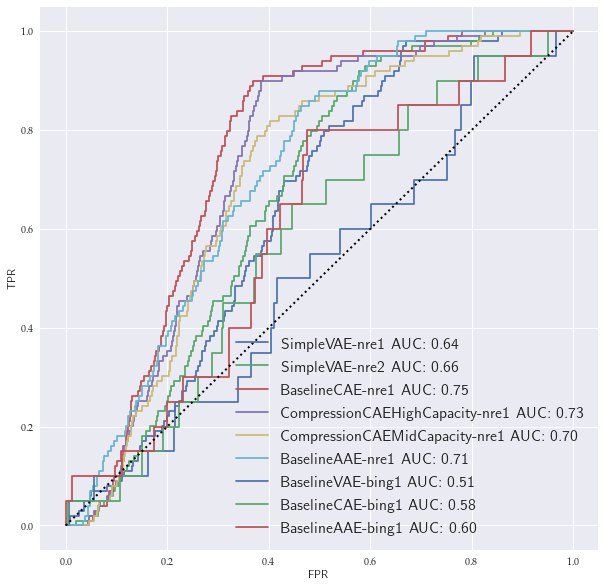

Random ROC AUC: 0.5


In [87]:
fig, ax = plt.subplots(figsize=(10,10))
for sn, res in result_catalog.items():

    scores = res['scores']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, iou_results[sn]['labels'])
    
    ax.plot(fpr, tpr, label=f'{sn} AUC: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.legend(fontsize=16)
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.show()
print('Random ROC AUC: 0.5')

In [95]:
plt.style.use('../../utils/_extras/primary.mplstyle')

# View distibution of IoUs for typical and novel samples
for sn, res in iou_results.items():
    
    plt.figure(figsize=(8, 8))
    sns.histplot(data=res['scores'][novs], color='C5', alpha=0.3,  stat='count', lw=0, 
                 fill=True, kde=True, label='Novel')
    sns.histplot(data=res['scores'][~novs], color='C2', alpha=0.3, stat='count', lw=0, 
                 fill=True, kde=True, label='Typical')
    plt.legend()
    plt.title(sn)
    plt.show()
        
    plt.figure(figsize=(8, 8))
    sns.histplot(data=res['scores'][novs], color='C5', alpha=0.3,  stat='density', lw=0, 
                 fill=True, kde=True, label='Novel')
    sns.histplot(data=res['scores'][~novs], color='C2', alpha=0.3, stat='density', lw=0, 
                 fill=True, kde=True, label='Typical')
    plt.legend()
    plt.title(sn)
    plt.show()

2021-05-23 17:46:01,326 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:01,331 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:01,331 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:01,332 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:01,332 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:01,332 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:01,333 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:01,333 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:01,333 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:01,333 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,336 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:01,541 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,542 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,542 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:01,542 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-23 17:46:01,543 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:01,544 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:01,545 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:01,556 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:01,556 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:01,557 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:01,557 - DEBUG -

2021-05-23 17:46:01,600 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/0e9cf75fab9c01f6cd9a63a91b8e7e3b.dvi
2021-05-23 17:46:01,602 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:01,603 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:01,604 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:01,604 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:01,604 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:01,605 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:01,605 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:01,605 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:01,606 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:01,606 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:01,655 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:01,656 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:01,656 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:01,656 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:01,657 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,657 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,658 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:01,660 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/fde1dedb53831ab853edd2bb4fc715cc.png /home/brahste/.cache/matplotlib/tex.cache/c3ec0b22b0b6cb3f95e221e809e07549.dvi
2021-05-23 17:46:01,812 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larss

2021-05-23 17:46:01,992 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:01,992 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:01,993 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:01,993 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:01,994 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:01,994 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,994 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:01,995 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:01,995 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:01,995 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:01,995 - DEBUG - Liberation Sans font

2021-05-23 17:46:02,169 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/99d531398f1c395f466c683efbe25d5e.png /home/brahste/.cache/matplotlib/tex.cache/0e9cf75fab9c01f6cd9a63a91b8e7e3b.dvi
2021-05-23 17:46:02,316 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:02,317 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:02,318 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:46:02,318 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 17:46:02,318 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 17:46:02,319 - DEBUG - STREAM b'IDAT' 149 194
2021-05-23 17:46:02,319 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:02,320 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:02,321 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:02,321 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:02,321 - DEBUG - Bi

2021-05-23 17:46:02,494 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:02,495 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:02,495 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:02,495 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:02,495 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:02,496 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:02,496 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:02,496 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:02,496 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:02,497 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:02,497 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 17:46:02,678 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:02,679 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:02,679 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:02,679 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:02,680 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:02,680 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:02,681 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:02,682 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:02,682 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:02,682 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:02,682 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:02,712 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:02,712 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:02,713 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:02,713 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:02,713 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:02,714 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:02,714 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:02,714 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:02,714 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:02,715 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:02,716 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:02,749 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:02,750 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:02,750 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:02,750 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:02,751 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:02,751 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:02,752 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:02,752 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:02,752 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:02,752 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:02,753 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:46:03,085 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:03,085 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:03,085 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,086 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,086 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:03,086 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-23 17:46:03,086 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:03,088 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:03,088 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:03,089 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:03,265 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:03,265 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:03,265 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:03,266 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:03,266 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:03,266 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:03,267 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:03,267 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:03,267 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:03,268 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,268 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:03,590 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:03,592 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:03,592 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:03,593 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:03,593 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:03,593 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:03,593 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:03,594 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:03,594 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:03,594 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:03,594 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:03,770 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:03,770 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:03,770 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,770 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,771 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:03,771 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/7a33e005b99ef922d6006efa28cf378b.png /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-23 17:46:03,916 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:03,918 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:03,918 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:46:03,918 - DEBUG - STREAM b'tRNS' 101 1

2021-05-23 17:46:03,949 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:03,949 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:03,950 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/2040f6f9d1ddaf3e74cf5fcee13c4a1a.png /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 17:46:04,099 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:04,100 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:04,100 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:46:04,101 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 17:46:04,101 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 17:46:04,102 - DEBUG - STREAM b'IDAT' 149 535
2021-05-23 17:46:04,102 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:04,103 - DEBUG - Arial font is not compat

2021-05-23 17:46:04,311 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,311 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,311 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,312 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,312 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,312 - DEBUG - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,313 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,313 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.t

2021-05-23 17:46:04,337 - DEBUG - findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,338 - DEBUG - findfont: score(<Font 'padmaa-Bold.1.1' (padmaa-Bold.1.1.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,338 - DEBUG - findfont: score(<Font 'Ani' (ani.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,338 - DEBUG - findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:46:04,338 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans' (VeraBd.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,339 - DEBUG - findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal 300 normal>) = 11.145
2021-05-23 17:46:04,339 - DEBUG - findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:46:04,341 - DEBUG - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.3

2021-05-23 17:46:04,365 - DEBUG - findfont: score(<Font 'Kinnari' (Kinnari-Italic.ttf) italic normal 500 normal>) = 11.145
2021-05-23 17:46:04,365 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,366 - DEBUG - findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-23 17:46:04,366 - DEBUG - findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,367 - DEBUG - findfont: score(<Font 'Padauk Book' (PadaukBook-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,367 - DEBUG - findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,367 - DEBUG - findfont: score(<Font 'Loma' (Loma-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,368 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.

2021-05-23 17:46:04,398 - DEBUG - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,398 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,399 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,399 - DEBUG - findfont: score(<Font 'Lato' (Lato-Black.ttf) normal normal 900 normal>) = 10.525
2021-05-23 17:46:04,399 - DEBUG - findfont: score(<Font 'Lohit Odia' (Lohit-Odia.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,400 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBd.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,400 - DEBUG - findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,401 - DEBUG - findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic no

2021-05-23 17:46:04,424 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,424 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
2021-05-23 17:46:04,425 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal 500 normal>) = 11.145
2021-05-23 17:46:04,425 - DEBUG - findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,425 - DEBUG - findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,426 - DEBUG - findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,426 - DEBUG - findfont: score(<Font 'Lohit Devanagari' (Lohit-Devanagari.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,426 - DEBUG - findfont: score(<Font 'mry_KacstQurn' (mry_KacstQurn.ttf) normal 

2021-05-23 17:46:04,451 - DEBUG - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,451 - DEBUG - findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,451 - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,452 - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,452 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,452 - DEBUG - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,453 - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,453 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2021-05-23 

2021-05-23 17:46:04,476 - DEBUG - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2021-05-23 17:46:04,477 - DEBUG - findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,478 - DEBUG - findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,479 - DEBUG - findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,479 - DEBUG - findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMono.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,480 - DEBUG - findfont: score(<Font 'msbm10' (msbm10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,480 - DEBUG - findfont: score(<Font 'OpenSymbol' (opens___.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,481 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:4

2021-05-23 17:46:04,503 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2021-05-23 17:46:04,504 - DEBUG - findfont: score(<Font 'Saab' (Saab.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,504 - DEBUG - findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,505 - DEBUG - findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal 700 normal>) = 11.335
2021-05-23 17:46:04,506 - DEBUG - findfont: score(<Font 'Tlwg Typist' (TlwgTypist-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:46:04,507 - DEBUG - findfont: score(<Font 'Purisa' (Purisa-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-23 17:46:04,507 - DEBUG - findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 200 normal>) = 11.24
2021-05-23 17:46:04,508 - DEBUG - findfont: score(<Font 'Ubuntu' (Ubuntu-B.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,5

2021-05-23 17:46:04,535 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
2021-05-23 17:46:04,535 - DEBUG - findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:46:04,535 - DEBUG - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,536 - DEBUG - findfont: score(<Font 'RaghuMalayalam' (RaghuMalayalamSans-Regular.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,536 - DEBUG - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,536 - DEBUG - findfont: score(<Font 'Samyak Tamil' (Samyak-Tamil.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,538 - DEBUG - findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,538 - DEBUG - findfont: score(<Font 'Waree' (Waree-Bold.ttf) no

2021-05-23 17:46:04,566 - DEBUG - findfont: score(<Font 'Keraleeyam' (Keraleeyam.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,566 - DEBUG - findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,567 - DEBUG - findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
2021-05-23 17:46:04,567 - DEBUG - findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
2021-05-23 17:46:04,567 - DEBUG - findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 100 normal>) = 10.335
2021-05-23 17:46:04,568 - DEBUG - findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-05-23 17:46:04,569 - DEBUG - findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 500 normal>) = 10.145
2021-05-23 17:46:04,569 - DEBUG - findfont: score(<Font 'Sawasdee' (Sawasdee-Bold.ttf) normal normal 700 normal>) = 10.335
2021-05-23 17:46:04,569 - DEBUG - 

2021-05-23 17:46:04,623 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:04,623 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:04,623 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:04,623 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:04,624 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:04,624 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:04,625 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:04,625 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:04,625 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:04,626 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:04,626 - DEBUG - Liberation Sans font

2021-05-23 17:46:04,820 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/87a7e1415122fe78011201022ff8c638.png /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:04,970 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:04,971 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:04,972 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:46:04,972 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 17:46:04,972 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 17:46:04,973 - DEBUG - STREAM b'IDAT' 149 402
2021-05-23 17:46:04,974 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:04,974 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:04,974 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:04,975 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:04,975 - DEBUG - Bi

2021-05-23 17:46:05,016 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,016 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:05,017 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,018 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,018 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,018 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,030 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,030 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,030 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,031 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,031 - DEBUG - Texti

2021-05-23 17:46:05,063 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,063 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,064 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,064 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,064 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,064 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,065 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,065 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,066 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,066 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:05,066 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:05,107 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,107 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:05,108 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,108 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,108 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,109 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e5e322fdddbe6793c3847197ff838d63.dvi
2021-05-23 17:46:05,109 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,110 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,111 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,111 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:05,145 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,146 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,146 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,147 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,147 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,148 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,148 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:05,149 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,149 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,149 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,149 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:05,184 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,184 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:05,185 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,185 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,185 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,186 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:05,186 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,188 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,188 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,188 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:05,223 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,223 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,224 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:05,225 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,226 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,226 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,227 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,227 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,228 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,228 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,229 - DEB

2021-05-23 17:46:05,271 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:05,272 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,272 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,272 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,273 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,273 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,274 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,274 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,274 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,274 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,275 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:05,479 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,479 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,480 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,480 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,481 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:05,481 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:05,481 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,482 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,482 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,483 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6ca9ec77f0adfa643d38aef07125fc47.dvi
2021-05-23 17:46:05,483 - DEBUG - D

2021-05-23 17:46:05,660 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,660 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,660 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,661 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,662 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,662 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,662 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,663 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,663 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,663 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:05,664 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:05,991 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:05,991 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:05,992 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bc6688989c8857da069db2f014f63052.dvi
2021-05-23 17:46:05,992 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:05,994 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:05,995 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:05,995 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:05,996 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:05,996 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:05,996 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:05,997 - DEB

2021-05-23 17:46:06,172 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:06,172 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:06,172 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:06,172 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:06,173 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:06,173 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:06,173 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,173 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,174 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:06,174 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/ebaa25ff3febf252d2d4bdc0dd417e6f.

2021-05-23 17:46:06,501 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:06,502 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:06,502 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:06,502 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:06,502 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:06,503 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:06,503 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:06,503 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,503 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,504 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:06,504 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:06,684 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:06,684 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:06,684 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:06,684 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:06,685 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,685 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,685 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:06,685 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:06,686 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:06,686 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:06,687 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:06,901 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:06,901 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:06,902 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:06,902 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:06,902 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:06,903 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:06,903 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:06,903 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:06,903 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:06,904 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:06,904 - DEBUG - Texti

2021-05-23 17:46:06,970 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:06,970 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:06,971 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:06,972 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:06,973 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:06,973 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,974 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:06,974 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:06,976 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:06,976 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:07,190 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:07,191 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:07,191 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:07,192 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:07,192 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:07,192 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,192 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,193 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,193 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:07,193 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:07,194 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:07,242 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:07,242 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:07,243 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:07,243 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,243 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,244 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,246 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:07,246 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:07,246 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:07,247 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,247 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:07,277 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,277 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,278 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,278 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:07,278 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:07,278 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:07,279 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,279 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,279 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:07,279 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d479ffaa8d76e04e283f2b2a73d46254.dvi
2021-05-23 17:46:07,286 - DEBUG - D

2021-05-23 17:46:07,471 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,471 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,471 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:07,472 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:07,474 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:07,474 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:07,474 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,474 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,475 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,475 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:07,475 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:07,798 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,798 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:07,799 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/798d56fe5d7b88c994356e1c10aa55a0.dvi
2021-05-23 17:46:07,800 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:07,802 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:07,802 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:07,803 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:07,803 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,803 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,803 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,804 - DEB

2021-05-23 17:46:07,979 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:07,979 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:07,980 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:07,980 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:07,980 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:07,980 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:07,981 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,982 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:07,982 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:07,983 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/27751e3608614548d2e92f3cf40f1c4c.

2021-05-23 17:46:08,310 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,310 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:08,310 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:08,310 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,311 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,311 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,311 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,311 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,312 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,312 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,312 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:08,493 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,494 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,494 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,495 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,497 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,497 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,497 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,498 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:08,498 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:08,499 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:08,534 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,535 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,535 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,535 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,535 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:08,536 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:08,537 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:08,537 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:08,538 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,538 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:08,572 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,572 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,573 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:08,573 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:08,573 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,574 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:08,574 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:08,574 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,574 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,575 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,575 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:46:08,619 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,619 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,619 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,619 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,620 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-23 17:46:08,621 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:08,622 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:08,622 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:08,623 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,623 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:08,668 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:08,668 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:08,669 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,669 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,669 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,670 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,670 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,670 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,670 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,671 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-23 17:46:08,672 - DEBUG - D

2021-05-23 17:46:08,890 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:08,891 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:08,891 - DEBUG - STREAM b'PLTE' 41 54
2021-05-23 17:46:08,892 - DEBUG - STREAM b'tRNS' 107 17
2021-05-23 17:46:08,892 - DEBUG - STREAM b'pHYs' 136 9
2021-05-23 17:46:08,893 - DEBUG - STREAM b'IDAT' 157 583
2021-05-23 17:46:08,894 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:08,894 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:08,894 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,895 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:08,895 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:08,895 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,896 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-23 17:46:08,940 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:08,941 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:08,941 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:08,942 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:08,942 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:08,942 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,943 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,943 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,944 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,944 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,944 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:08,983 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:08,984 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:08,984 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:08,984 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,985 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:08,985 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:08,986 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-23 17:46:08,988 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:08,989 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:08,990 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:09,023 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,023 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,024 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,024 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50b063103f9808b81526cf7a814e0d24.dvi
2021-05-23 17:46:09,025 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,025 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,026 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,026 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,027 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,027 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,028 - DEBUG -

2021-05-23 17:46:09,071 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d479ffaa8d76e04e283f2b2a73d46254.dvi
2021-05-23 17:46:09,072 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,073 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,074 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,074 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,075 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,075 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,075 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,076 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,077 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,077 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:09,115 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,116 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,116 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,116 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,117 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,117 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,117 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,118 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,118 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,118 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,119 - DEBUG - Apple Chancery 

2021-05-23 17:46:09,160 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,160 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,161 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,164 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,164 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,164 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,165 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,165 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d479ffaa8d76e04e283f2b2a73d46254.dvi
2021-05-23 17:46:09,166 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,170 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:09,209 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,210 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,210 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,210 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,210 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/50eec38d441c8ed960a0cc999ea4df86.dvi
2021-05-23 17:46:09,214 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,215 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,215 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,216 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,216 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:09,260 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,260 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,260 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c6f9e34e1befa64719a05f81a2d78e74.dvi
2021-05-23 17:46:09,262 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,263 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,263 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,265 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,265 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,266 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,266 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,267 - DEB

2021-05-23 17:46:09,303 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/5fe699a26323dbe822435c62963947c3.dvi
2021-05-23 17:46:09,305 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,307 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,307 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,308 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,308 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,308 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,308 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,309 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,309 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,309 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:09,353 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,353 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,354 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,354 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,354 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,355 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,355 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,355 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,356 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,356 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,356 - DEBUG - Apple Chancery 

2021-05-23 17:46:09,399 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,400 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,400 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,401 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,402 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,402 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,402 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,402 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/cfb8be411b49bc3eeb4565f8ea08805b.dvi
2021-05-23 17:46:09,403 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,405 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:09,441 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-23 17:46:09,442 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,443 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,444 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,445 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,445 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,445 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,446 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,446 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,446 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,447 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:09,509 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,509 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,509 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,514 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,515 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,516 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,517 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,518 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:09,518 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,519 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:09,579 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/f89cadae47d2c0cf02eff195687f931e.dvi
2021-05-23 17:46:09,579 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,580 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,580 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,581 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,582 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,582 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,582 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,583 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,583 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,584 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:09,792 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,792 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,793 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,793 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,793 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,793 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,794 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:09,795 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,796 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,796 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:09,842 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,842 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,843 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:09,844 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:09,845 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:09,848 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:09,848 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,849 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,849 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,850 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,850 - DEBUG -

2021-05-23 17:46:09,892 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:09,893 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:09,893 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:09,893 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:09,893 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:09,894 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:09,894 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:09,894 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:09,894 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,895 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:09,896 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:10,223 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:10,223 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:10,224 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:10,224 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:10,224 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:10,225 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:10,225 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:10,225 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,225 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,226 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:10,226 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:10,405 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:10,406 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,406 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,406 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:10,407 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:10,408 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:10,408 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:10,408 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:10,408 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:10,409 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:10,409 - DEBUG - Apple Chancery 

2021-05-23 17:46:10,589 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:10,589 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:10,590 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:10,591 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:10,591 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:10,592 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:10,592 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:10,592 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:10,592 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:10,593 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:10,593 - DEBUG - Texti

2021-05-23 17:46:10,624 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:10,624 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:10,625 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:10,625 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:10,625 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:10,626 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:10,626 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:10,626 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:10,626 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:10,627 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:10,627 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:10,827 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:10,827 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:10,828 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,828 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,828 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:10,829 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:10,829 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:10,831 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:10,832 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:10,832 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:10,868 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:10,869 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:10,869 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:10,870 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:10,870 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:10,871 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:10,872 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:10,872 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,873 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:10,873 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:10,873 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:11,056 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,056 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,056 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,057 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,057 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,057 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,057 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,058 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,058 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,058 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:11,058 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:11,258 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,259 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:11,259 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:11,260 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,261 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,261 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:11,262 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:11,262 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,262 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,262 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,263 - DEBUG - Texti

2021-05-23 17:46:11,305 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,305 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,306 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,306 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,306 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,306 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,307 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,307 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,307 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:11,309 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:11,351 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,351 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,352 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,352 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,352 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,353 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9814159c3fac1cfbf0b21ea20703e45f.dvi
2021-05-23 17:46:11,353 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:11,354 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,355 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,355 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:11,391 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,392 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,392 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-23 17:46:11,393 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:11,394 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,394 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,394 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:11,395 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:11,395 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,395 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,396 - DEB

2021-05-23 17:46:11,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:11,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,437 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,437 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,438 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,438 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,438 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,438 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,439 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,439 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,439 - DEBUG - Arial font is 

2021-05-23 17:46:11,475 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,475 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:11,476 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:11,476 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,476 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,477 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,478 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,478 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,479 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,483 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,483 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:11,540 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,541 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,541 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,541 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,542 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,542 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,543 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,543 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,544 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d7f16887d1c83bd1259c35f91cc6aca3.dvi
2021-05-23 17:46:11,544 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:11,585 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,585 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,585 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,586 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,586 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,587 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-23 17:46:11,587 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:11,589 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,589 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,590 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:11,784 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-23 17:46:11,785 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:11,787 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:11,787 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:11,787 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:11,788 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:11,788 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:11,788 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:11,788 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,789 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,789 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:11,963 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:11,964 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:11,964 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:11,964 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,964 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:11,965 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:11,965 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/71f11815fd48988eb7301a1d649ab6d8.png /home/brahste/.cache/matplotlib/tex.cache/3220faf6b0d3737196ba522b1121d87d.dvi
2021-05-23 17:46:12,113 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:12,114 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:12,115 

2021-05-23 17:46:12,292 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,292 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,292 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,292 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,293 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,293 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,293 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:12,293 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,294 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,294 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,294 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:12,347 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,348 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,348 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,348 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,349 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,349 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,350 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,350 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,351 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,351 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,351 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:12,402 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,402 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,402 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,402 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,403 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,403 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,403 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:12,404 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 17:46:12,405 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:12,407 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:12,615 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/15b809054f2bfc014278508ea22c17c8.dvi
2021-05-23 17:46:12,615 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:12,621 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,621 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,621 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,622 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,622 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,622 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,623 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,623 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,623 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:12,656 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,656 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,656 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,657 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,657 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,657 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,657 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,658 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,658 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,658 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,659 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:12,697 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,698 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,698 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,702 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,702 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,702 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,703 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,703 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,703 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:12,704 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:12,705 - DEBUG - D

2021-05-23 17:46:12,739 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:12,740 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,740 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,740 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,741 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,741 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,741 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,742 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,742 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,742 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:12,742 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 17:46:12,779 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,780 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:12,780 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:12,780 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-23 17:46:12,782 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:12,783 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,784 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,784 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,784 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,785 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,785 - DEBUG -

2021-05-23 17:46:12,976 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:12,976 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:12,980 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:12,980 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:12,981 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:12,981 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:12,981 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:12,982 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:12,982 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:12,982 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:12,982 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:13,011 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,012 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,012 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,012 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,012 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,013 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,013 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,013 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,014 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,014 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,014 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:13,073 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,073 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,073 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,073 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,074 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,075 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,075 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,076 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,076 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,076 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,077 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:13,119 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,119 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,120 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,120 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,120 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,120 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,121 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,121 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,121 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,121 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,122 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:13,308 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,309 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,309 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,309 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,309 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,310 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,310 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,310 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 17:46:13,310 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,312 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:13,511 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,512 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/15b809054f2bfc014278508ea22c17c8.dvi
2021-05-23 17:46:13,512 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,515 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,516 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,516 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,516 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,517 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,517 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,517 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,517 - DEBUG - Texti

2021-05-23 17:46:13,561 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,561 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,561 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,562 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,562 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,562 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,563 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,563 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,564 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,565 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,565 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:13,604 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,604 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,605 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,605 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,606 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,606 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,606 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:13,607 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,608 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,608 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:13,644 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,644 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,644 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,645 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:13,648 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,649 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,649 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,649 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,650 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,650 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,650 - DEBUG -

2021-05-23 17:46:13,690 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,690 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,690 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,690 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,691 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,691 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,691 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,691 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,692 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,692 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,692 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:13,736 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,736 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,737 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-23 17:46:13,737 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,738 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,739 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,739 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,739 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,740 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,740 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,740 - DEB

2021-05-23 17:46:13,782 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,782 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,782 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,782 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,783 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,784 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,784 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,785 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:13,785 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,786 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:13,823 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,823 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,824 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,824 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,824 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:13,825 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,826 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,826 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,826 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,827 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:13,869 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,869 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,870 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,870 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,870 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,871 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,871 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,871 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,872 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,872 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,872 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:46:13,916 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,917 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,917 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,917 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:13,918 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3220faf6b0d3737196ba522b1121d87d.dvi
2021-05-23 17:46:13,919 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:13,920 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,920 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,920 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,921 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:13,961 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:13,961 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:13,962 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:13,962 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:13,962 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:13,963 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:13,963 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:13,963 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:13,965 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:13,965 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:13,965 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:14,029 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,032 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,033 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,034 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:14,035 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:14,035 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:14,036 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,036 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,036 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,037 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:14,516 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,517 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,517 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,517 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,517 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,517 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,518 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,518 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,518 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,518 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,519 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:14,548 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:14,548 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-23 17:46:14,549 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:14,550 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,550 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,551 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,551 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,551 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,552 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,552 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,552 - DEBUG - Texti

2021-05-23 17:46:14,751 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,751 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,752 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,753 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,754 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,754 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,755 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,756 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,757 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,757 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:14,758 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:14,812 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,812 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,813 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,813 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,813 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:14,816 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 17:46:14,817 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:14,819 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,819 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,819 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:14,857 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-23 17:46:14,858 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:14,859 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,860 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,860 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,860 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,861 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,861 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,861 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,861 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,862 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:14,897 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,897 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,897 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,898 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,898 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,898 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,898 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,899 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,899 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,899 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,902 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:14,937 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,938 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,938 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,938 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,939 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,939 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,939 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,940 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,940 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:14,941 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:14,941 - DEBUG - Arial font is 

2021-05-23 17:46:14,979 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:14,979 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:14,983 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:14,983 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:14,986 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:14,986 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:14,986 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:14,987 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:14,987 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,988 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:14,988 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:15,030 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:15,030 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-23 17:46:15,032 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:15,035 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:15,036 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:15,036 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:15,037 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:15,037 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:15,037 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:15,037 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:15,038 - DEBUG - Texti

2021-05-23 17:46:15,080 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:15,081 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:15,081 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:15,081 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:15,082 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:15,082 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:15,083 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:15,083 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:15,086 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:15,087 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:15,087 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:15,859 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:15,859 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:15,860 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:15,860 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:15,861 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:15,861 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:15,861 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:15,861 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:15,862 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:15,862 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:15,862 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:15,897 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:15,897 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:15,898 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:15,898 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:15,898 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:15,899 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:15,899 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:15,899 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:15,900 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:15,900 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:15,902 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:16,102 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,102 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,103 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,103 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,103 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,104 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,104 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,104 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,105 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,105 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,105 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:46:16,138 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,138 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,138 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,138 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,139 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,139 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,139 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,139 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,140 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-23 17:46:16,141 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:16,175 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:16,176 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,177 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,177 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,177 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,177 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,178 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,178 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,178 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,179 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,181 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:16,366 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,366 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,366 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,367 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,367 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,367 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,368 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,368 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,368 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,369 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,369 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:16,563 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,563 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,564 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,564 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,564 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:16,564 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:16,565 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,565 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,566 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,567 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:16,618 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,618 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,618 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,619 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,619 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,619 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,619 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,620 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,620 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,620 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,620 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:16,666 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,668 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,669 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,670 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,670 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,670 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,671 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,671 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,671 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,672 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-23 17:46:16,673 - DEBUG - D

2021-05-23 17:46:16,709 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,710 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,710 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,711 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,711 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,712 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,712 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/491cca92ef7fc4f0496df6cd4270a1ae.dvi
2021-05-23 17:46:16,713 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:16,714 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,714 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:16,753 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:16,755 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,755 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,756 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,756 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,756 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,756 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,757 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,757 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,757 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,758 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:16,800 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,800 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:16,801 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:16,801 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,801 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,802 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,802 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,802 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,803 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,803 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,804 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:16,843 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:16,843 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:16,843 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:16,844 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:16,844 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:16,844 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:16,845 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:16,845 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:16,848 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:16,848 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:16,849 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:17,059 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:17,060 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:17,060 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:17,060 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:17,061 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,061 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,061 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:17,062 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:17,063 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:17,063 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:17,104 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:17,105 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,105 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,105 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:17,106 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:17,107 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:17,107 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:17,109 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:17,109 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:17,110 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:17,110 - DEBUG - Apple Chancery 

2021-05-23 17:46:17,295 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:17,295 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:17,296 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:17,296 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:17,296 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:17,296 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:17,297 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:17,297 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:17,299 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,299 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,299 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:17,621 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:17,621 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:17,622 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:17,622 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:17,622 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:17,623 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:17,623 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:17,623 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,623 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,624 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:17,624 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:17,799 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:17,799 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,799 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:17,800 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:17,800 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/49c45b09433ccdffa163bb9da67e1383.dvi
2021-05-23 17:46:17,801 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:17,803 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:17,803 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:17,804 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:17,804 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:17,985 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:17,985 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/522741de97037f716b6db38352a5dae1.dvi
2021-05-23 17:46:17,986 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:17,987 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:17,987 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:17,987 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:17,988 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:17,988 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:17,988 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:17,988 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:17,989 - DEBUG - Texti

2021-05-23 17:46:18,038 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,038 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,038 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,039 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,039 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,039 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,039 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,040 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,040 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:18,041 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:18,092 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,093 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/f89cadae47d2c0cf02eff195687f931e.dvi
2021-05-23 17:46:18,094 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,095 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,098 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,098 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,098 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,099 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,099 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,099 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,099 - DEBUG - Texti

2021-05-23 17:46:18,300 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,300 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,300 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,301 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,301 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,301 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,301 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,302 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:18,303 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,303 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:18,338 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,339 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,339 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,340 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,341 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:18,341 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,342 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,342 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,342 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,343 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:18,405 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,405 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,405 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,406 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,406 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,407 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,407 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,408 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,408 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,409 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/798d56fe5d7b88c994356e1c10aa55a0.dvi
2021-05-23 17:46:18,409 - DEBUG - D

2021-05-23 17:46:18,459 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,460 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:18,461 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,462 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,462 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,463 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,463 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,463 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,464 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,464 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,464 - DEBUG - Texti

2021-05-23 17:46:18,506 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,507 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,507 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,508 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,508 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,508 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,508 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,509 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,509 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,510 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,510 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:18,546 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,546 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,547 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,547 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,548 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,549 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,550 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,550 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,551 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,552 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,552 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:18,592 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,593 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,594 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,594 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,594 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,595 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,595 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,595 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,596 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,596 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,596 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 17:46:18,634 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,634 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,635 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,637 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/681f96a2424d9e6ece162e15d6c6b491.dvi
2021-05-23 17:46:18,637 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,640 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,640 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,641 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,641 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,642 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,642 - DEBUG -

2021-05-23 17:46:18,707 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,707 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,708 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,708 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,709 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,709 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,709 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,710 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,710 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/1cf3590f778703d69d97158c5fd1ddb3.png /home/brahste/.cache/matplotlib/tex.cache/b87e702b87d27807fc96e639a397d5c6.dvi

2021-05-23 17:46:18,913 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,913 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,913 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,913 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,914 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:18,914 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:18,915 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:18,915 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,915 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,916 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,917 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:18,966 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:18,967 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:18,967 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:18,969 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:18,969 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:18,970 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:18,970 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:18,970 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:18,970 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:18,971 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:18,971 - DEB

2021-05-23 17:46:19,010 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:19,010 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,011 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,012 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,012 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,013 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,013 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,013 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,013 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,014 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,014 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:19,054 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,054 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,055 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,055 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,056 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,056 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,056 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,057 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-23 17:46:19,058 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,060 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:19,101 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,102 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,102 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,103 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,103 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,103 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,104 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,104 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,104 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,105 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,105 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:19,144 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,144 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,144 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,145 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,147 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,148 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,148 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,148 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,150 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,150 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:19,151 - DEBUG - D

2021-05-23 17:46:19,190 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,191 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,191 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,192 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,192 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,192 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,193 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:19,194 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,194 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,196 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:19,233 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,234 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,234 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,234 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,235 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,235 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,235 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,236 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,236 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,236 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,237 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:19,275 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,275 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,275 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,276 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,276 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,276 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3f4bcc55be4a0fd2d33bdcf3e9c04e00.dvi
2021-05-23 17:46:19,277 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,278 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,279 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,279 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:19,314 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,315 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,315 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,315 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,315 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,316 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,317 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,317 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,317 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,318 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,318 - DEBUG - family: serif, font: Palatino, in

2021-05-23 17:46:19,358 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,359 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,359 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,360 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,360 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,360 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,360 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,361 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,361 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,361 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,362 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:46:19,429 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,429 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,429 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,430 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,430 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,430 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,431 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,431 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,431 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,432 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:19,433 - DEBUG - D

2021-05-23 17:46:19,488 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,489 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,489 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,490 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,490 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,490 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,491 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,491 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,491 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,491 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,492 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 17:46:19,716 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,716 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,716 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:19,717 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,717 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,718 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,719 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,719 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2d26aa2bf1680aa68c723cedd8972500.dvi
2021-05-23 17:46:19,720 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,721 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:19,764 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:19,764 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,766 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:19,766 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,767 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/82bf971d84f8c5eb6c953fd2acfaa7fd.dvi
2021-05-23 17:46:19,768 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,769 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,769 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,769 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,770 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:19,957 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:19,957 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/104f0c66aaa256b37474b9ca7b53baca.dvi
2021-05-23 17:46:19,959 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:19,961 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:19,961 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:19,962 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:19,962 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:19,962 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:19,963 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:19,963 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:19,963 - DEBUG - Texti

2021-05-23 17:46:20,141 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,142 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,142 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,142 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:20,142 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:20,143 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,143 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,143 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,143 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/0e1fc5cccfef459d87f4479d2e98311b.png /home/brahste/.cache/matplotlib/tex.cache/46de17df7d48b7418e4a03283110f16c.dvi

2021-05-23 17:46:20,469 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,469 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,470 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,470 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,470 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:20,470 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:20,471 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,471 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,471 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,471 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,472 - DEBUG - Arial font is 

2021-05-23 17:46:20,651 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,651 - DEBUG - dvipng -bg Transparent -D 100.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/a7b8fbb2608e8fad2a1a1e124df3db4e.png /home/brahste/.cache/matplotlib/tex.cache/b4210e3ee9381975076c84e537ee4edd.dvi
2021-05-23 17:46:20,799 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 17:46:20,800 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 17:46:20,801 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 17:46:20,801 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 17:46:20,801 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 17:46:20,802 - DEBUG - STREAM b'IDAT' 149 322
2021-05-23 17:46:20,803 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,803 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:20,803 - DEBUG - Liberation Sans font is not compatible with

2021-05-23 17:46:20,836 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,836 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,837 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,837 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:20,838 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:20,839 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,839 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:20,839 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:20,839 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,840 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,840 - DEBUG -

2021-05-23 17:46:20,870 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:20,871 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:20,872 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,872 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:20,872 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:20,872 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,873 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,873 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,873 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,873 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:20,874 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:20,911 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,911 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,911 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,912 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,912 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:20,913 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:20,913 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,913 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,914 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,914 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:20,915 - DEBUG - D

2021-05-23 17:46:20,949 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:20,951 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,952 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:20,952 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:20,952 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,953 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,953 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,953 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,953 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:20,954 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:20,954 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:20,991 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,992 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:20,992 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:20,992 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:20,993 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:20,993 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:20,993 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:20,995 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:20,995 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:20,996 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:20,996 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:21,057 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,057 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,058 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,058 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,059 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,059 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,059 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,060 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:21,060 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,061 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,061 - DEBUG - Liberation Sans font

2021-05-23 17:46:21,262 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,265 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,265 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,265 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,266 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,266 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,266 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:21,268 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:21,269 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:21,282 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:21,317 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/21200b591d8cddf0dbe72708e084d24b.dvi
2021-05-23 17:46:21,317 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:21,321 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,321 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,322 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,322 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,322 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,322 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,323 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,323 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,323 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:21,357 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,358 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,358 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,358 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,359 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,359 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,359 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,360 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,360 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,360 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,360 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:21,396 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,396 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,397 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,397 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,397 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,398 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,398 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,398 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,398 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:21,399 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,399 - DEBUG - Arial font is 

2021-05-23 17:46:21,442 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,442 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,443 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,443 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,443 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,443 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,444 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,444 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,444 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,445 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,445 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:21,487 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,487 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,487 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:21,488 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:21,489 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:21,490 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,490 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,490 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,491 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,491 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,491 - DEBUG -

2021-05-23 17:46:21,530 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3220faf6b0d3737196ba522b1121d87d.dvi
2021-05-23 17:46:21,530 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:21,531 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,532 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,532 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,532 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,533 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,533 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,533 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,533 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,534 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:21,579 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,580 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,580 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,580 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:21,580 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:21,581 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,581 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,582 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,582 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,583 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,583 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:21,621 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:21,621 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:21,621 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:21,622 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:21,622 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,622 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:21,622 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:21,623 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:21,623 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:21,623 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:21,624 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:22,272 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:22,274 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:22,286 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,287 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,287 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,288 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,288 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,288 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,289 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,289 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,289 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:22,332 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,332 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,333 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,334 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,335 - DEBUG - latex -interaction=nonstopmode --halt-on-error /home/brahste/.cache/matplotlib/tex.cache/b830c71648cedfaa2ac94e392261a9f2.tex
2021-05-23 17:46:22,506 - DEBUG - b"This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n\n(/home/brahste/.cache/matplotlib/tex.cache/b830c71648cedfaa2ac94e392261a9f2.tex\nLaTeX2e <2017-04-15>\nBabel <3.18> and hyphenation patterns for 3 language(s) loaded.\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDo

2021-05-23 17:46:22,541 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:22,542 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,543 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,543 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,543 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,544 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,544 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,545 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,545 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,545 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,545 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:22,586 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,587 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,587 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,588 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,588 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,588 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,588 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,589 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,589 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,589 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,590 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:22,633 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,633 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,634 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,635 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,635 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,636 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,636 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,636 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,637 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,637 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,637 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 17:46:22,689 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,690 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,690 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,690 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,691 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,691 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,691 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,692 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,692 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-23 17:46:22,693 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:22,740 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,741 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,741 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,741 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,741 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,742 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-23 17:46:22,743 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:22,747 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,748 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,748 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:22,787 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:22,789 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:22,790 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,791 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,793 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,794 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,795 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,795 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,796 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,796 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,796 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:22,835 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,835 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,835 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,836 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,837 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:22,837 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:22,837 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:22,838 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,838 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,839 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,839 - DEBUG - Apple Chancery 

2021-05-23 17:46:22,884 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:22,885 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:22,885 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:22,885 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:22,886 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:22,886 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:22,886 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,887 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:22,887 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:22,887 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 17:46:22,888 - DEBUG - D

2021-05-23 17:46:23,106 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,106 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,106 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,107 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/b830c71648cedfaa2ac94e392261a9f2.dvi
2021-05-23 17:46:23,107 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,110 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,110 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,110 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,111 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,111 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,111 - DEBUG -

2021-05-23 17:46:23,152 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,154 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,155 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,155 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,156 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,158 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,158 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,158 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:23,159 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,159 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,159 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:23,196 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,197 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,197 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:23,198 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,198 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,199 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,199 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,200 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,200 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:23,200 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:23,241 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,242 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,242 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,242 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,242 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,243 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:23,245 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,245 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,247 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,247 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:23,287 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,287 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,287 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,287 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,288 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:23,288 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,288 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,289 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,289 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,291 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,292 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:23,338 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,338 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,339 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:23,339 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,340 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,341 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,341 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,342 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,342 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,342 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,343 - DEB

2021-05-23 17:46:23,386 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 17:46:23,387 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,388 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,388 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,389 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,389 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,389 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,390 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,390 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:23,390 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,391 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:23,437 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,437 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,438 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,438 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,439 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,439 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,439 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:23,439 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:23,440 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,440 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,440 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:23,650 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:23,650 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,651 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:23,652 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:23,652 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:23,653 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:23,654 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:23,654 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:23,655 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:23,655 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:23,690 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:23,691 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:23,691 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:23,691 - DEBUG - Apple Chancery font is not compatible with usetex.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2021-05-23 17:46:24,235 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,235 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,235 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,235 - DEBUG -

2021-05-23 17:46:24,265 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,265 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,266 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,266 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,266 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,266 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,267 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,267 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,268 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,268 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-23 17:46:24,268 - DEBUG - D

2021-05-23 17:46:24,294 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,294 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,294 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,295 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,295 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 17:46:24,297 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,298 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,298 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,299 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,299 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:24,335 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,335 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,335 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,336 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,336 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,336 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,337 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,338 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,338 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,339 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,339 - DEBUG - Arial font is 

2021-05-23 17:46:24,375 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,376 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,376 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,376 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,376 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,377 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,377 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,377 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,378 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,378 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,378 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:24,456 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,457 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,457 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,457 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,458 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,458 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 17:46:24,459 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,461 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,461 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,461 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:24,523 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,523 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,523 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,524 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,524 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,525 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,525 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,526 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,526 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,526 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,526 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:24,569 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,569 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,569 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,570 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,570 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,570 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,571 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,571 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,571 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,572 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:24,573 - DEBUG - D

2021-05-23 17:46:24,614 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,615 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,615 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,615 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,616 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,616 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,617 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:24,618 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,620 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,620 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:24,661 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,661 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,661 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,662 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,662 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,662 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,662 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,663 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,663 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,664 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,664 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:24,697 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,698 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/643cf41e7951529fcc9a3fcb10c62b53.dvi
2021-05-23 17:46:24,698 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,702 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,703 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,704 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,704 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,704 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,705 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,705 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,705 - DEBUG - Texti

2021-05-23 17:46:24,742 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,745 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,746 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,746 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,747 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,747 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,747 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,748 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,748 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,748 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,749 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:24,785 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,786 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,786 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,786 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,787 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,787 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,788 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,789 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,789 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,789 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,790 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:24,827 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,828 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,828 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,828 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,829 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,829 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,829 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,830 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,830 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,830 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,830 - DEBUG - Liberation Sans font

2021-05-23 17:46:24,869 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,869 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,870 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,870 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,870 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,871 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,871 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:24,871 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:24,872 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,872 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:24,872 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:24,911 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:24,912 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/cfb8be411b49bc3eeb4565f8ea08805b.dvi
2021-05-23 17:46:24,913 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:24,914 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:24,915 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:24,915 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:24,916 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:24,916 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:24,916 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:24,917 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:24,917 - DEBUG - Texti

2021-05-23 17:46:25,522 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,523 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,523 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,524 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,524 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,525 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/f89cadae47d2c0cf02eff195687f931e.dvi
2021-05-23 17:46:25,525 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,525 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,526 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,526 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:25,556 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,556 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,557 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:25,558 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,558 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,558 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,559 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,559 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,560 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,560 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,560 - DEB

2021-05-23 17:46:25,587 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:25,588 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,589 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,589 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,589 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,589 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,590 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,590 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,590 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,590 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,591 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:25,616 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,617 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,617 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,617 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,617 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,618 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,618 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,618 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-23 17:46:25,619 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,620 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:25,651 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,651 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,651 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,651 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,652 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,652 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,652 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,652 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,653 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,653 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,653 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:25,685 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,685 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,686 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,687 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,687 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:25,687 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,688 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,688 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,688 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,689 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:25,716 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,716 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,717 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:25,717 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,718 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,718 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,719 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,719 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,719 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,719 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,720 - DEB

2021-05-23 17:46:25,748 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:25,748 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,749 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,749 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,750 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,750 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,750 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,751 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,751 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,751 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,751 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:25,779 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,779 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,779 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,780 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,780 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,780 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,780 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,781 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6ca9ec77f0adfa643d38aef07125fc47.dvi
2021-05-23 17:46:25,781 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,782 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:25,810 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,811 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,811 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,811 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,811 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,812 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,813 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,813 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,813 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,813 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,814 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:25,841 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,841 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,841 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,842 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,842 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,842 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,842 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,843 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,843 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,843 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,843 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:46:25,905 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,906 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:25,906 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:25,906 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:25,906 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,907 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,907 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,908 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/64b7c4161e7c5b975ab6916e7cef4ede.dvi
2021-05-23 17:46:25,909 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,910 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:25,964 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:25,965 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:25,965 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 17:46:25,966 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:25,967 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:25,968 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:25,968 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:25,968 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:25,969 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:25,969 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:25,969 - DEB

2021-05-23 17:46:26,007 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:26,008 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:26,008 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:26,008 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:26,009 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:26,009 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,009 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:26,009 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:26,010 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:26,010 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,010 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:26,047 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:26,047 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:26,048 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,048 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:26,048 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:26,049 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:26,050 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,050 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,050 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:26,051 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:26,051 - DEBUG - D

2021-05-23 17:46:26,093 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:26,096 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,096 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,097 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:26,097 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:26,099 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:26,100 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:26,100 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:26,101 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:26,102 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,102 - DEBUG - Apple Chancery 

2021-05-23 17:46:26,145 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,146 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:26,147 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:26,147 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:26,147 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,148 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,148 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:26,148 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-23 17:46:26,149 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:26,150 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:26,191 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,191 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:26,192 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-23 17:46:26,193 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:26,195 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:26,195 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:26,195 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:26,196 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:26,196 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:26,196 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,197 - DEB

2021-05-23 17:46:26,230 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/63ca6e0be05709794b698f3f5833e43e.dvi
2021-05-23 17:46:26,231 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:26,232 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:26,233 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:26,233 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:26,233 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:26,234 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:26,234 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:26,234 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:26,234 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:26,235 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:26,965 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:26,966 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,966 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:26,966 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:26,966 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:26,968 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:26,969 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:26,970 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:26,975 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:26,976 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:27,017 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,018 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,018 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:27,019 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,019 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,020 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,021 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,021 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,021 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,021 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,022 - DEB

2021-05-23 17:46:27,061 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,061 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,061 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,062 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,062 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,062 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,062 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,063 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,063 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,064 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9814159c3fac1cfbf0b21ea20703e45f.dvi
2021-05-23 17:46:27,065 - DEBUG - D

2021-05-23 17:46:27,104 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,106 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,106 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,107 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,107 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,107 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,108 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,108 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,109 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,109 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,110 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:27,144 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,144 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,144 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,145 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,145 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,145 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:27,147 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,147 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,147 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,148 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:27,176 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,176 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,177 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:27,178 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,178 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,179 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,179 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,179 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,180 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,180 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,180 - DEB

2021-05-23 17:46:27,207 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,207 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,208 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,208 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,208 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,208 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,209 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,209 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,211 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,211 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25c1b725f827a8629238f3775925c694.dvi
2021-05-23 17:46:27,213 - DEBUG - D

2021-05-23 17:46:27,240 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,241 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,241 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,241 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,241 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,242 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,242 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,242 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,242 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,242 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,243 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:27,290 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,290 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,290 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,290 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,291 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,291 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,291 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,291 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,292 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,292 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,292 - DEBUG - family: sans-serif, font: sa

2021-05-23 17:46:27,335 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,335 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,335 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,335 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,336 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,336 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,336 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,336 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,337 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,337 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,337 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:27,371 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,372 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,372 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,372 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,372 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,372 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,373 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,373 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-23 17:46:27,373 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,374 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:27,402 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,402 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,403 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,403 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,403 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3318017fb31e43c0ebfdae9d6a130da1.dvi
2021-05-23 17:46:27,404 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,405 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,405 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,406 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,406 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:27,434 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,434 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,434 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/be1054efb11919c0b518672140abdf0c.dvi
2021-05-23 17:46:27,435 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,436 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,437 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,437 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,437 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,437 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,438 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,438 - DEB

2021-05-23 17:46:27,466 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,467 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,467 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,467 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,467 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,468 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,468 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,468 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:27,468 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:27,469 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,469 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:27,499 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:27,499 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:27,500 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:27,500 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,500 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,501 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,501 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,502 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,502 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,502 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,502 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 17:46:27,532 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:27,532 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:27,533 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:27,533 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:27,533 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,533 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:27,534 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:27,534 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d7f16887d1c83bd1259c35f91cc6aca3.dvi
2021-05-23 17:46:27,534 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:27,536 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:28,251 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,251 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,251 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,252 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,252 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,252 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,253 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,253 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,253 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,253 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,254 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:28,296 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,296 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,298 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,300 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,301 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,301 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,301 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,302 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,302 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,302 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6e669d4270a0d6fadcab81941d2c82f8.dvi
2021-05-23 17:46:28,303 - DEBUG - D

2021-05-23 17:46:28,339 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,339 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,339 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,339 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,340 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,340 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,343 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-23 17:46:28,346 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,347 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,347 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:28,386 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,388 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,389 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,389 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,389 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,389 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,390 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,390 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,391 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,391 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,391 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:28,430 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,430 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,431 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,431 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,432 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,433 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,433 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,434 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,434 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,435 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,435 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:28,479 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,479 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,479 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,479 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,480 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,481 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,481 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,482 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,482 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,483 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,483 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:28,521 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,522 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,522 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,522 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,523 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,523 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,525 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,526 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,526 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9a1cd5f6f69715f9ab1f4e024d553a53.dvi
2021-05-23 17:46:28,527 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:28,562 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,563 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-23 17:46:28,565 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,567 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,567 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,568 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,568 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,568 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,569 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,569 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,570 - DEBUG - Texti

2021-05-23 17:46:28,605 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,605 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,605 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,606 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,606 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,606 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,607 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,607 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,607 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,607 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,608 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 17:46:28,664 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,665 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,665 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,665 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,666 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,667 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,667 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,667 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,668 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,668 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,669 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:28,722 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,722 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,722 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,723 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,723 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,723 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,724 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 17:46:28,725 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,727 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,727 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:28,758 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,758 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/aab5cc4d22d25565e9490903bf3c04ba.dvi
2021-05-23 17:46:28,759 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,760 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,760 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,761 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,761 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,761 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,762 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,762 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,762 - DEBUG - Texti

2021-05-23 17:46:28,789 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,790 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,791 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,791 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,792 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,792 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,792 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,792 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,792 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,793 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,793 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:28,820 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,820 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,821 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,821 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,821 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,821 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,821 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,822 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,822 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,822 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,822 - DEBUG - Liberation Sans font

2021-05-23 17:46:28,850 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,850 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,850 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,850 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,850 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,851 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,851 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,851 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,851 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,852 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,852 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:28,887 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,887 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,888 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,888 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,888 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,888 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,889 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e33d6e46c120caff2604b893a09d1332.dvi
2021-05-23 17:46:28,889 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,891 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,891 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:28,915 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,916 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,916 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,918 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/80ebdd707c25a7c9dae65042bc3e9fd2.dvi
2021-05-23 17:46:28,918 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,920 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,920 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,921 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,921 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,921 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,922 - DEBUG -

2021-05-23 17:46:28,949 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/607d7f8e4af1852682b6a5934ce86039.dvi
2021-05-23 17:46:28,950 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:28,951 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,951 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,952 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,952 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,952 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,952 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,953 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:28,953 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:28,953 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:28,981 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:28,981 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,981 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:28,981 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:28,982 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:28,982 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:28,982 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:28,982 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:28,983 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:28,983 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:28,983 - DEBUG - Apple Chancery 

2021-05-23 17:46:29,461 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,462 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,462 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,463 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,463 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,463 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,464 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,464 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,464 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:29,465 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:29,519 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,519 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,519 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,520 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,520 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,520 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,521 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,521 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,522 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,522 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,522 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:29,567 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:29,567 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,568 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,568 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,568 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,569 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,569 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,569 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,571 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,572 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,572 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:29,611 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,611 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,612 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,612 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,612 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,612 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,613 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,613 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,613 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,614 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,614 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 17:46:29,656 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,657 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/798d56fe5d7b88c994356e1c10aa55a0.dvi
2021-05-23 17:46:29,657 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:29,659 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,660 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,660 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,660 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,660 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,661 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,661 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,661 - DEBUG - Texti

2021-05-23 17:46:29,707 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,707 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,708 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,708 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,708 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,709 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,709 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,709 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,710 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:29,711 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:29,752 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,753 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,753 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,754 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,754 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,754 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:29,755 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:29,755 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,756 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,756 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:29,792 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,793 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,793 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,793 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,794 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,795 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,795 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,796 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,796 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,796 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,797 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc',

2021-05-23 17:46:29,833 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,833 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,834 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,834 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,836 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-23 17:46:29,837 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:29,838 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,839 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,839 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,839 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:29,883 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,884 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,884 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,885 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,885 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:29,886 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:29,886 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,886 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:29,886 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,887 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6134acbfb19d192b077a5db8a0594e2a.dvi
2021-05-23 17:46:29,888 - DEBUG - D

2021-05-23 17:46:29,952 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:29,953 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:29,954 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:29,954 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:29,955 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:29,955 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:29,955 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:29,956 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:29,956 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:29,956 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:29,956 - DEBUG - Texti

2021-05-23 17:46:30,017 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:30,017 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,018 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:30,018 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:30,018 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,019 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,019 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,019 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,020 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/529bfac556d34e70e638742a816d5538.dvi
2021-05-23 17:46:30,021 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46

2021-05-23 17:46:30,068 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:30,069 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,069 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,071 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,071 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,072 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/7fb174ba49f9be712fb633a8577762e4.dvi
2021-05-23 17:46:30,073 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:30,074 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:30,075 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:30,075 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:30,116 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,116 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,118 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/efec8296de9918f3450d8d95431443de.dvi
2021-05-23 17:46:30,118 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:30,120 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:30,122 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:30,123 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:30,123 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:30,123 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:30,124 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,124 - DEB

2021-05-23 17:46:30,168 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,168 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:30,168 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:30,169 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,169 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,169 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,169 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,170 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:30,170 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:30,170 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:30,171 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:30,838 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,838 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:30,838 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:30,838 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,839 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,839 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,839 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,839 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/983a2a6b0b66424692d45994f6bb1f67.dvi
2021-05-23 17:46:30,840 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:30,841 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:30,868 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:30,869 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:30,869 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:30,869 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:30,870 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:30,870 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,870 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:30,870 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:30,871 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,871 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,871 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:30,917 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:30,917 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,917 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:30,918 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:30,918 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:30,918 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:30,918 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:30,919 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:30,919 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:30,919 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:30,919 - DEBUG - Apple Chancery 

2021-05-23 17:46:31,111 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,112 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,112 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,112 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,112 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,113 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,113 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,113 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,113 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,114 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,114 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:31,154 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,154 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,154 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,155 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,155 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,155 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,156 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,157 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/104f0c66aaa256b37474b9ca7b53baca.dvi
2021-05-23 17:46:31,158 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,159 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 17:46:31,201 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,202 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,202 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,202 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,203 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/371b2ad568146a968cf5fde2df359eac.dvi
2021-05-23 17:46:31,204 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,205 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,206 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,207 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,207 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:31,249 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/104f0c66aaa256b37474b9ca7b53baca.dvi
2021-05-23 17:46:31,252 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,253 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,254 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,254 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,255 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,255 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,255 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,255 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,256 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,256 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:31,301 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,301 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,301 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,302 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,303 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,303 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,303 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,304 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,304 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,304 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,304 - DEBUG - Apple Chancery 

2021-05-23 17:46:31,350 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,353 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,353 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,354 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,355 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,355 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,356 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,356 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,356 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,357 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,357 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:31,398 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,398 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,398 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,399 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,399 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,399 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,400 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,400 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,400 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,401 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/9a1cd5f6f69715f9ab1f4e024d553a53.dvi
2021-05-23 17:46:31,402 - DEBUG - D

2021-05-23 17:46:31,442 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,442 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,443 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,444 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,444 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,445 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,447 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/785282500a4d51b49a557f86713ca2e3.dvi
2021-05-23 17:46:31,448 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,449 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,450 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46

2021-05-23 17:46:31,489 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,490 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,491 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,492 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,492 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,492 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,493 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,493 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,493 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,493 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,494 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:31,532 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,532 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,532 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,533 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,533 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,533 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,534 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,534 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,535 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,535 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,535 - DEBUG - Textile font is not compatible with usetex

2021-05-23 17:46:31,572 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,572 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,573 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,574 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,574 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,575 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/c6d1e822a77e13cb9fc43d10e58336b1.dvi
2021-05-23 17:46:31,575 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,578 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,578 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,579 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:4

2021-05-23 17:46:31,641 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,641 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,643 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,643 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,646 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,647 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,647 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,648 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,648 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,649 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,649 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

2021-05-23 17:46:31,705 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,705 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,705 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,706 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,706 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,706 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,706 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,707 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,707 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,707 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,708 - DEBUG - DejaVu Sans font is not 

2021-05-23 17:46:31,754 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,754 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,754 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:31,759 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,760 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,761 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,761 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,761 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,762 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,762 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,763 - DEB

2021-05-23 17:46:31,804 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 17:46:31,805 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,805 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,806 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,806 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,806 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:31,807 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:31,807 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:31,807 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:31,808 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:31,808 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 17:46:31,847 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:31,848 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,848 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:31,849 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:31,849 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ab6382df2a4438b69cf8b3ef2bf4e92a.dvi
2021-05-23 17:46:31,850 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:31,852 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:31,852 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:31,852 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:31,853 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 17:46:32,410 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:32,411 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:32,411 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:32,411 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:32,412 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:32,412 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:32,412 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:32,412 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:32,412 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:32,413 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 17:46:32,413 - DEBUG - D

2021-05-23 17:46:32,440 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 17:46:32,441 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:32,441 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:32,441 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:32,443 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:32,443 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:32,443 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:32,443 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:32,444 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:32,444 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:32,444 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 17:46:32,489 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:32,489 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:32,489 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:32,489 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17:46:32,490 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 17:46:32,490 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:32,490 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:32,490 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:32,491 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:32,491 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:32,491 - DEBUG - family: sans-serif, font: sa

2021-05-23 17:46:32,532 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 17:46:32,532 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 17:46:32,532 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 17:46:32,533 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 17:46:32,533 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 17:46:32,533 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 17:46:32,533 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 17:46:32,534 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 17:46:32,534 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 17:46:32,534 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 17:46:32,534 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 17

In [15]:
# # Want to plot the novel-typical score overlap below
# typical_scores = scores[[not bool(b) for b in binary_labels]]

# novel_scores = scores[[bool(b) for b in binary_labels]]

# # plt.hist(scores, bins=25)
# plt.hist(novel_scores, bins=25, label='Novel', alpha=0.5)
# plt.hist(typical_scores, bins=25, label='Typical', alpha=0.5)

# plt.legend()
# plt.show()

NameError: name 'scores' is not defined

2021-05-23 19:00:54,236 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:54,236 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:54,237 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:54,237 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:54,237 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:54,238 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:54,238 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:54,239 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:54,239 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:54,239 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:54,240 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:54,442 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:00:54,443 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:54,444 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:54,445 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:54,445 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:54,446 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:54,446 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:54,447 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:54,447 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:54,447 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:54,448 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:00:54,640 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:54,641 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:54,641 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:54,642 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:54,642 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:54,642 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:54,643 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:54,643 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:54,644 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:54,644 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:54,644 - DEBUG - Arial font is 

2021-05-23 19:00:54,843 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:54,843 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:54,844 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:54,844 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:54,845 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:54,846 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:54,846 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:54,847 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:54,847 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:54,847 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:54,848 - DEBUG -

2021-05-23 19:00:55,040 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:55,040 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,041 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,041 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,041 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,042 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,042 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:55,042 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,043 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,044 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:55,046 - DEBUG - latex -interaction=nonstopmode --

2021-05-23 19:00:55,406 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ccdc3cf86f9e340d9932adcb3bfc5b09.dvi
2021-05-23 19:00:55,407 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:55,408 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:55,408 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:55,409 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:55,409 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,409 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,410 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,410 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,410 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,411 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:00:55,607 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,607 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,608 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,608 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,608 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,609 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:55,610 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,610 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,610 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:55,611 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 19:00:55,611 - DEBUG - D

2021-05-23 19:00:55,652 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,655 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,656 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:55,656 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,658 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,658 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:55,658 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 19:00:55,659 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:55,660 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:55,661 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:00:55,704 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,704 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,705 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:55,705 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 19:00:55,706 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:55,710 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:55,710 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:55,711 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:55,711 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,712 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,712 - DEBUG -

2021-05-23 19:00:55,791 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:00:55,791 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:55,793 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:55,793 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:55,793 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:55,794 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,794 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,795 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,795 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,795 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,796 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:00:55,840 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:55,841 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:55,841 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:55,842 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,842 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,842 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,843 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,843 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,844 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:55,844 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,844 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:55,885 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:55,886 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:55,886 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:55,886 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:55,887 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:55,887 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:55,887 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,887 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:55,888 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:55,888 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:55,889 - DEBUG - D

2021-05-23 19:00:56,078 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:56,078 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:56,078 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:56,079 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,079 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,079 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:56,079 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:56,080 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:56,080 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:56,080 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:56,080 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 19:00:56,403 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 19:00:56,404 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 19:00:56,404 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 19:00:56,405 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 19:00:56,405 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 19:00:56,405 - DEBUG - STREAM b'IDAT' 149 143
2021-05-23 19:00:56,406 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:56,407 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:56,407 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:56,407 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:56,407 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:56,408 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:56,408 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-0

2021-05-23 19:00:56,438 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:56,438 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:56,438 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:56,438 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:56,439 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,439 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,439 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:56,439 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/fb8c40c3982df16ebebffcbc53358506.png /home/brahste/.cache/matplotlib/tex.cache/4bbe7242ca5ece2c3913582af6dd7b77.dvi
2021-05-23 19:00:56,589 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsso

2021-05-23 19:00:56,769 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:56,769 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:56,769 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:56,769 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:56,770 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:56,770 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,770 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:56,770 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:56,771 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:56,771 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:56,771 - DEBUG - Liberation Sans font

2021-05-23 19:00:56,945 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/fab90f3e24697c5c3600a9210566ee62.png /home/brahste/.cache/matplotlib/tex.cache/25574f31ccedf400ce538eaaae9591fb.dvi
2021-05-23 19:00:57,092 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 19:00:57,093 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 19:00:57,094 - DEBUG - STREAM b'PLTE' 41 48
2021-05-23 19:00:57,094 - DEBUG - STREAM b'tRNS' 101 15
2021-05-23 19:00:57,095 - DEBUG - STREAM b'pHYs' 128 9
2021-05-23 19:00:57,095 - DEBUG - STREAM b'IDAT' 149 167
2021-05-23 19:00:57,096 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,096 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,097 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,097 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,097 - DEBUG - Bit

2021-05-23 19:00:57,129 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,129 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:57,130 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,131 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,131 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,131 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,132 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,132 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,132 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,133 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,133 - DEBUG - Texti

2021-05-23 19:00:57,164 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,165 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,165 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,166 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,167 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,167 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,167 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,168 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,168 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,168 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,168 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 19:00:57,213 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,214 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,214 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,214 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,214 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,215 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,215 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,215 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,215 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,216 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,216 - DEBUG - Bitstream Vera Sans font is not c

2021-05-23 19:00:57,408 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,408 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 19:00:57,410 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,411 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,412 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,412 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,412 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,412 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,413 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,413 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,413 - DEBUG - Texti

2021-05-23 19:00:57,463 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,464 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,464 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,464 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,464 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,465 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,465 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,465 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,466 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,466 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,466 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 19:00:57,506 - DEBUG - dvipng -bg Transparent -D 72.0 -T tight -o /home/brahste/.cache/matplotlib/tex.cache/aac8bac0f5aa320cb67893069bfb74ca.png /home/brahste/.cache/matplotlib/tex.cache/47ed1aa36428055da18ec1dc76184fe6.dvi
2021-05-23 19:00:57,657 - DEBUG - b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2021-05-23 19:00:57,658 - DEBUG - STREAM b'IHDR' 16 13
2021-05-23 19:00:57,659 - DEBUG - STREAM b'PLTE' 41 51
2021-05-23 19:00:57,659 - DEBUG - STREAM b'tRNS' 104 16
2021-05-23 19:00:57,660 - DEBUG - STREAM b'pHYs' 132 9
2021-05-23 19:00:57,660 - DEBUG - STREAM b'IDAT' 153 498
2021-05-23 19:00:57,661 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,661 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,662 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,662 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,662 - DEBUG - Bit

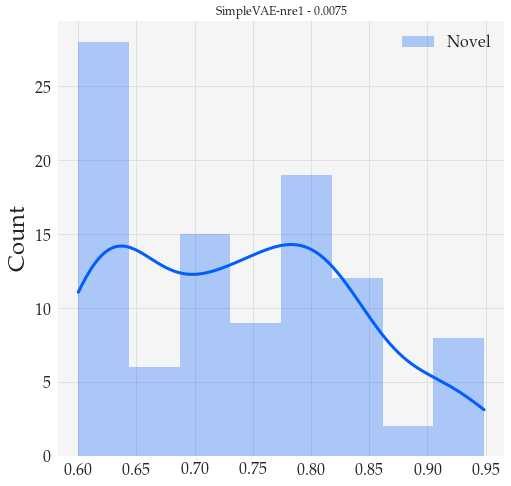

2021-05-23 19:00:57,795 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,796 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,796 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,796 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,797 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,797 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,797 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,797 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,798 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,798 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,798 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:57,842 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,842 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,843 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,843 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,843 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,844 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,844 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,844 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,845 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,845 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:57,846 - DEBUG - D

2021-05-23 19:00:57,888 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,888 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,888 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:57,889 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,889 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,891 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,892 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:57,892 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,893 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,893 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:00:57,938 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,938 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:57,938 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:57,939 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:57,940 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,941 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,941 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,942 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,942 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,942 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,943 - DEBUG -

2021-05-23 19:00:57,979 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:57,979 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:57,980 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:57,980 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:57,981 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:57,981 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:57,981 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:57,983 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:57,983 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:57,983 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:57,984 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:00:58,025 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,025 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,026 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,026 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,033 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,033 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,034 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,034 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,035 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,035 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,036 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:58,115 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,116 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,116 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,116 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,116 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,117 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,117 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,118 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,118 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,118 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:00:58,119 - DEBUG - D

2021-05-23 19:00:58,162 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,163 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,163 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,163 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,164 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,164 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,164 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd196af660a74f68991e2b30dd79cffe.dvi
2021-05-23 19:00:58,165 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,166 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,166 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:00:58,213 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,215 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,215 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,216 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ccdc3cf86f9e340d9932adcb3bfc5b09.dvi
2021-05-23 19:00:58,217 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,218 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,218 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,218 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,219 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,220 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,220 - DEBUG -

2021-05-23 19:00:58,257 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,257 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,258 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,258 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,258 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,259 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,259 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,260 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,262 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,262 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,262 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 19:00:58,298 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,298 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,298 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,299 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,299 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,299 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,299 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,300 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,300 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,300 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,301 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 19:00:58,347 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,348 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,348 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,349 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,349 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,349 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,349 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 19:00:58,351 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,353 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,353 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:00:58,394 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,394 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,394 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,395 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 19:00:58,395 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,396 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,397 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,397 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,397 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,398 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,398 - DEBUG -

2021-05-23 19:00:58,434 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,435 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,435 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,435 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,436 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,437 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,437 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,438 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,438 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 19:00:58,479 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,480 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,480 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,480 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,481 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,481 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,482 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,483 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,483 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,484 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,484 - DEBUG - Textile font is not compatible with usetex

2021-05-23 19:00:58,527 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,528 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,528 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,529 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,529 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,529 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,530 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,530 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,531 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 19:00:58,531 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00

2021-05-23 19:00:58,736 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,737 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,738 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,738 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,739 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,739 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 19:00:58,740 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,746 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,747 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,747 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:0

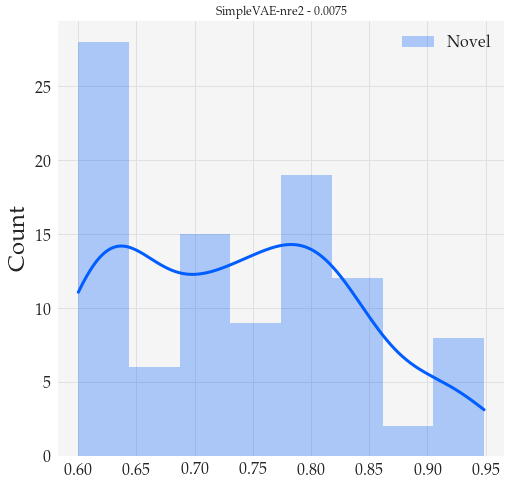

2021-05-23 19:00:58,857 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,858 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,859 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,859 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,859 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,859 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,860 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,860 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,861 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,861 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,861 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:58,897 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,897 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,898 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:58,898 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,898 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,898 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,899 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,899 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,899 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,899 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:58,900 - DEBUG - D

2021-05-23 19:00:58,935 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:58,936 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:58,936 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:58,936 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,937 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,937 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,937 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:58,938 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,938 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,939 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:00:58,983 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,983 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:58,983 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:58,984 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:58,985 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:58,986 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:58,986 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:58,986 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:58,986 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:58,987 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:58,987 - DEBUG -

2021-05-23 19:00:59,028 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:00:59,029 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:59,030 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:59,030 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:59,031 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:59,031 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:59,031 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:59,032 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:59,032 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:59,032 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:59,032 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:00:59,080 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:59,080 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00:59,080 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:00:59,081 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:59,082 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:59,082 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:59,082 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:59,083 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:59,083 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:59,084 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:59,084 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:00:59,156 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:00:59,156 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:00:59,157 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:00:59,157 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:59,158 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:59,158 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:59,159 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:59,159 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:59,159 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:59,160 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:00:59,160 - DEBUG - D

2021-05-23 19:00:59,201 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:00:59,201 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:00:59,202 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:00:59,202 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:00:59,203 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:00:59,204 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:00:59,204 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd196af660a74f68991e2b30dd79cffe.dvi
2021-05-23 19:00:59,205 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:00:59,206 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:00:59,206 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:00

2021-05-23 19:01:00,211 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,212 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,212 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,212 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,212 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,213 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,213 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,213 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,213 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,214 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,214 - DEBUG - family: sans-serif, font: sa

2021-05-23 19:01:00,250 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,251 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,251 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,251 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,252 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,252 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,252 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,253 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/25574f31ccedf400ce538eaaae9591fb.dvi
2021-05-23 19:01:00,254 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,257 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2

2021-05-23 19:01:00,285 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,285 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,285 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,286 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,286 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/3e4df96a5b1dc6517618bc22f9ba990c.dvi
2021-05-23 19:01:00,287 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,288 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,288 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,289 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,289 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 

2021-05-23 19:01:00,325 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,325 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,325 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/49c45b09433ccdffa163bb9da67e1383.dvi
2021-05-23 19:01:00,326 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,327 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,328 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,329 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,330 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,331 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,331 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,331 - DEB

2021-05-23 19:01:00,372 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,372 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,372 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,373 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,373 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,373 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,373 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,374 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,375 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,375 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,375 - DEBUG - DejaVu Sans font is not 

2021-05-23 19:01:00,413 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,413 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,414 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,414 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,415 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,415 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,415 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,416 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,416 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,417 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,417 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:00,628 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,630 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,633 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,634 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,634 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,635 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,635 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e7a007d82557b32176694cc36fbe9ac2.dvi
2021-05-23 19:01:00,636 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,639 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,641 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

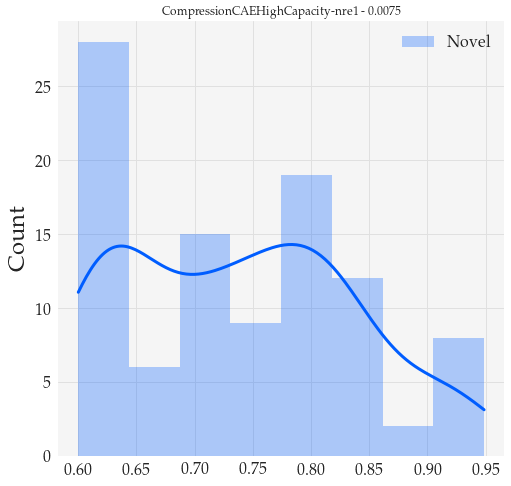

2021-05-23 19:01:00,778 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,779 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,779 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,779 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,780 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,780 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,781 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,781 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,782 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,782 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,782 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:00,831 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,832 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,833 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,833 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,833 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,834 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,834 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,835 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,835 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,835 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:00,836 - DEBUG - D

2021-05-23 19:01:00,876 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,877 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,877 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:00,877 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,878 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,878 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,878 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:00,880 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,880 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,881 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:00,927 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,928 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:00,928 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:00,929 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:00,929 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,930 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,930 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,931 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,931 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,931 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,933 - DEBUG -

2021-05-23 19:01:00,971 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:00,972 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:00,972 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:00,973 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:00,973 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:00,973 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:00,974 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:00,974 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:00,974 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:00,974 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:00,975 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:01:01,016 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,017 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,017 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,017 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,018 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,018 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,018 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,018 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,019 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,019 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,019 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:01,100 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,101 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,101 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,101 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,102 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,102 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,102 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,103 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,103 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,103 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:01:01,104 - DEBUG - D

2021-05-23 19:01:01,147 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,148 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,149 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,149 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,150 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,150 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,151 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd196af660a74f68991e2b30dd79cffe.dvi
2021-05-23 19:01:01,151 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,152 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,152 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:01,196 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,197 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,197 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,198 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ccdc3cf86f9e340d9932adcb3bfc5b09.dvi
2021-05-23 19:01:01,198 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,199 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,200 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,202 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,202 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,203 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,204 - DEBUG -

2021-05-23 19:01:01,245 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,246 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,247 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,247 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,248 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,248 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,248 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,249 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,249 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,249 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,250 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 19:01:01,289 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,290 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,290 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,290 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,290 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,291 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,292 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,292 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,292 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,292 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,293 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 19:01:01,342 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,342 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,343 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,343 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,343 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,343 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,344 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 19:01:01,345 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,346 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,346 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:01,385 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,386 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,387 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,387 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/33de1047671d5063467a9aae09aed86e.dvi
2021-05-23 19:01:01,388 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,389 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,389 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,390 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,390 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,390 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,390 - DEBUG -

2021-05-23 19:01:01,430 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,432 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,435 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,436 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,436 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,436 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,437 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,437 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,437 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,438 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

2021-05-23 19:01:01,472 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,473 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,473 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,473 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,474 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,474 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,475 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,477 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,477 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,478 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,478 - DEBUG - Textile font is not compatible with usetex

2021-05-23 19:01:01,517 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,517 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,517 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,518 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,518 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,519 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,519 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,520 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,520 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 19:01:01,521 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01

2021-05-23 19:01:01,729 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,729 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,730 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,730 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,730 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,731 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8e78cbf20214890fa9d1cce476dcd9b0.dvi
2021-05-23 19:01:01,732 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,738 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,738 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,739 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:0

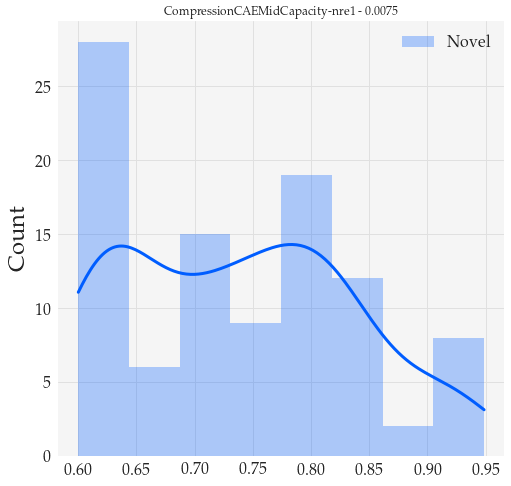

2021-05-23 19:01:01,851 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,851 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,852 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,852 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,853 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,853 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,854 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,854 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,854 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,855 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,855 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:01,895 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,895 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,895 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:01,898 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,899 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,899 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,900 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,900 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,900 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,901 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:01,901 - DEBUG - D

2021-05-23 19:01:01,936 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:01,936 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:01,937 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:01,937 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,937 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,937 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,938 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:01,939 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,940 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,940 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:01,988 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,988 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:01,989 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:01,989 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:01,991 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:01,991 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:01,992 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:01,992 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:01,992 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:01,993 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:01,993 - DEBUG -

2021-05-23 19:01:02,036 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:02,037 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:02,038 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,038 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:02,039 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:02,039 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,040 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,040 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:02,040 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,041 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,041 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:01:02,085 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,086 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:02,086 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:02,086 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,086 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,087 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:02,087 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,087 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,088 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,088 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,088 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:02,167 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,168 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,168 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:02,169 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,170 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,171 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,171 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,171 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,171 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:02,172 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/297963545ef441de9c7a5ba8d1a08c03.dvi
2021-05-23 19:01:02,172 - DEBUG - D

2021-05-23 19:01:02,215 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,215 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,216 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,216 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,217 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,217 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:02,217 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/bd196af660a74f68991e2b30dd79cffe.dvi
2021-05-23 19:01:02,218 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:02,219 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,220 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:02,259 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,259 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,260 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:02,260 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/ccdc3cf86f9e340d9932adcb3bfc5b09.dvi
2021-05-23 19:01:02,261 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:02,262 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,263 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:02,263 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:02,263 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,263 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,264 - DEBUG -

2021-05-23 19:01:02,301 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:02,301 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:02,302 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,302 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,303 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:02,303 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,306 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,306 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,306 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,307 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,307 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 19:01:02,350 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:02,350 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,351 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:02,351 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:02,352 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:02,352 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:02,352 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:02,353 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,353 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,353 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,354 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 19:01:02,398 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:02,398 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:02,398 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:02,399 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,399 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:02,399 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:02,400 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2f554728ce2be6dc9209a89cf3eb6c0d.dvi
2021-05-23 19:01:02,401 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:02,402 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:02,402 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

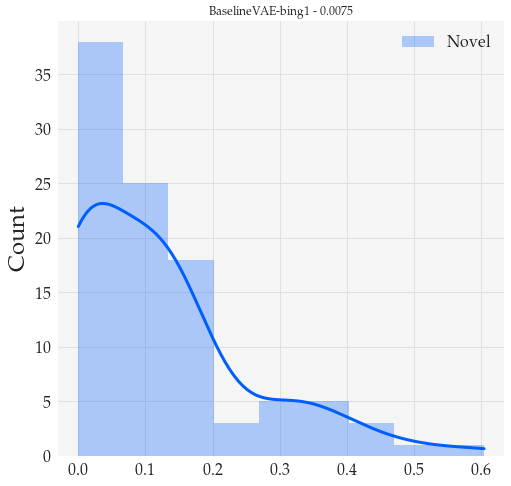

2021-05-23 19:01:03,877 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:03,877 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:03,877 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:03,878 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:03,878 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:03,879 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:03,879 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:03,879 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:03,880 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:03,880 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:03,881 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:03,934 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:03,934 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:03,934 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:03,936 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:03,937 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:03,937 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:03,937 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:03,937 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:03,938 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:03,938 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:03,939 - DEBUG - D

2021-05-23 19:01:03,994 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:03,995 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:03,996 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:03,996 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:03,997 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:03,997 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:03,998 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:03,998 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:03,999 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,000 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:04,050 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,051 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,054 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,054 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:04,055 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,055 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,056 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,056 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,057 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,057 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,058 - DEBUG -

2021-05-23 19:01:04,105 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:04,106 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,107 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,109 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,109 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,110 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,110 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,111 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,112 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,112 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,113 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:01:04,165 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,165 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,165 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,166 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,166 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,167 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,168 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,171 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,171 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,171 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,172 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:04,272 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,272 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,273 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,273 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,273 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,274 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,274 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,274 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,275 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,275 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2c75953a22ffc40effe1e5d99b859e13.dvi
2021-05-23 19:01:04,283 - DEBUG - D

2021-05-23 19:01:04,337 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,337 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,338 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,340 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,340 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,341 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,341 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-23 19:01:04,342 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,343 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,343 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:04,393 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,393 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,394 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,395 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/643cf41e7951529fcc9a3fcb10c62b53.dvi
2021-05-23 19:01:04,396 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,397 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,397 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,398 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,398 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,398 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,399 - DEBUG -

2021-05-23 19:01:04,450 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,450 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,450 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,451 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,451 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,451 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,451 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,452 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,452 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,452 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,452 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 19:01:04,523 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,523 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,526 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,526 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,526 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,527 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,527 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,527 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,528 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,528 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,528 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 19:01:04,586 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,587 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,587 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,587 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,588 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,588 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,588 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,589 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,589 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f4292f9e067a55fc0b6fc029737cc33.dvi
2021-05-23 19:01:04,589 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01

2021-05-23 19:01:04,637 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,638 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,638 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,638 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,639 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,639 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-23 19:01:04,640 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,641 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,641 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,642 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:0

2021-05-23 19:01:04,690 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,690 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,691 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/281dae30f0d26b10791d2d70f9fcde32.dvi
2021-05-23 19:01:04,692 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,693 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,693 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,694 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,694 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,695 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,695 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,695 - DEB

2021-05-23 19:01:04,743 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,743 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,743 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,744 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,744 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,744 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,744 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,745 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,745 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,745 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,746 - DEBUG - DejaVu Sans font is not 

2021-05-23 19:01:04,785 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,785 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,787 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,787 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,788 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:04,788 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:04,789 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:04,790 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,790 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,790 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,791 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 19:01:04,825 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:04,825 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:04,825 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 19:01:04,828 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:04,833 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:04,835 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:04,836 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:04,836 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:04,837 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:04,837 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:04,837 - DEB

2021-05-23 19:01:05,042 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,048 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,048 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,049 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,049 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,051 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,051 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,052 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,052 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,052 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,052 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05

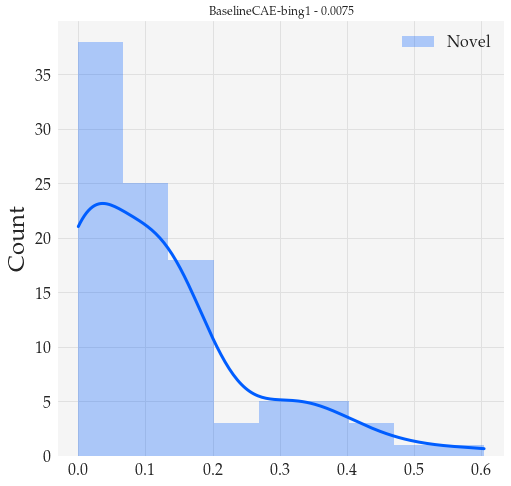

2021-05-23 19:01:05,164 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,165 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,165 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,166 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,166 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,167 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,167 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,167 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,168 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,168 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,168 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:05,209 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,210 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,210 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,210 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,210 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,211 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,212 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,212 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,212 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,213 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:05,213 - DEBUG - D

2021-05-23 19:01:05,255 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,255 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,256 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,256 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,256 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,257 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,258 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:05,259 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,260 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,260 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:05,327 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,327 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,327 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,328 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:05,329 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,329 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,330 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,331 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,331 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,332 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,332 - DEBUG -

2021-05-23 19:01:05,389 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/e15246af0c1a15790a6dd2b844e9ce83.dvi
2021-05-23 19:01:05,389 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,390 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,390 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,390 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,391 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,391 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,391 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,392 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,392 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,392 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\

2021-05-23 19:01:05,435 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,435 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,435 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,436 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,437 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,438 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,439 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,440 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,440 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,441 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,441 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19

2021-05-23 19:01:05,537 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,537 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,537 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,538 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,538 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,538 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,539 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,539 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,539 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,540 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/2b4c55c650c36a1e456e588f8fe04e44.dvi
2021-05-23 19:01:05,541 - DEBUG - D

2021-05-23 19:01:05,589 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,589 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,590 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,590 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,591 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,593 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,594 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/d57805ca30df78f885241e6b3aa903c5.dvi
2021-05-23 19:01:05,595 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,596 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,596 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01

2021-05-23 19:01:05,640 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,640 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,641 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,642 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/643cf41e7951529fcc9a3fcb10c62b53.dvi
2021-05-23 19:01:05,643 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,644 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,645 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,645 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,646 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,646 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,647 - DEBUG -

2021-05-23 19:01:05,691 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,691 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,692 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,692 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,692 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,692 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,693 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,693 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,693 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,694 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,695 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{ty

2021-05-23 19:01:05,755 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,755 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,756 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,756 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,756 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,756 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,757 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,757 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,757 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,757 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,758 - DEBUG - DejaVu Sans Mono font is not compa

2021-05-23 19:01:05,810 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,811 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,811 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,811 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,813 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,814 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,814 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,814 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,814 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/8f4292f9e067a55fc0b6fc029737cc33.dvi
2021-05-23 19:01:05,815 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01

2021-05-23 19:01:05,859 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,859 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,860 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,861 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,861 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,861 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/11d3f079bac7ef456ad4fcfef7ec6c36.dvi
2021-05-23 19:01:05,862 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,863 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,863 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,865 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:0

2021-05-23 19:01:05,909 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,909 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,910 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/281dae30f0d26b10791d2d70f9fcde32.dvi
2021-05-23 19:01:05,911 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:05,913 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,914 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,915 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,915 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:05,915 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:05,916 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,916 - DEB

2021-05-23 19:01:05,953 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:05,953 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:05,954 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:05,958 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:05,959 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,959 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:05,960 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:05,961 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:05,961 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:05,961 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:05,962 - DEBUG - DejaVu Sans font is not 

2021-05-23 19:01:06,005 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:06,005 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:06,006 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:06,006 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:06,006 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:06,007 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:06,007 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:06,007 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
2021-05-23 19:01:06,007 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:06,008 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:06,008 - DEBUG - Dvi: /home/brahste/.cache/matplot

2021-05-23 19:01:06,055 - DEBUG - Bitstream Vera Sans Mono font is not compatible with usetex.
2021-05-23 19:01:06,056 - DEBUG - family: monospace, font: Computer Modern Typewriter, info: ('cmtt', '\\usepackage{type1ec}')
2021-05-23 19:01:06,056 - DEBUG - Dvi: /home/brahste/.cache/matplotlib/tex.cache/6a9f0ed149fe1fd09f31f7aa6b5e81c4.dvi
2021-05-23 19:01:06,057 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:06,061 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:06,061 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:06,062 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:06,062 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:06,064 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:06,065 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:06,065 - DEB

2021-05-23 19:01:06,271 - DEBUG - Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2021-05-23 19:01:06,278 - DEBUG - family: serif, font: Palatino, info: ('ppl', '\\usepackage{mathpazo}')
2021-05-23 19:01:06,278 - DEBUG - Arial font is not compatible with usetex.
2021-05-23 19:01:06,279 - DEBUG - Liberation Sans font is not compatible with usetex.
2021-05-23 19:01:06,280 - DEBUG - DejaVu Sans font is not compatible with usetex.
2021-05-23 19:01:06,280 - DEBUG - Bitstream Vera Sans font is not compatible with usetex.
2021-05-23 19:01:06,280 - DEBUG - family: sans-serif, font: sans-serif, info: ('cmss', '')
2021-05-23 19:01:06,281 - DEBUG - Apple Chancery font is not compatible with usetex.
2021-05-23 19:01:06,281 - DEBUG - Textile font is not compatible with usetex.
2021-05-23 19:01:06,281 - DEBUG - family: cursive, font: Zapf Chancery, info: ('pzc', '\\usepackage{chancery}')
2021-05-23 19:01:06,281 - DEBUG - DejaVu Sans Mono font is not compatible with usetex.
IOPub m

In [133]:
# # View distibution of IoUs for typical and novel samples
# for sn, res in iou_results.items():
    
#     plt.figure(figsize=(8, 8))
#     sns.histplot(data=res['ious'][novs], color='C5', alpha=0.3,  stat='count', lw=0, 
#                  fill=True, kde=True, label='Novel')
# #     sns.histplot(data=res['ious'][~novs], color='C2', alpha=0.3, stat='count', lw=0, 
# #                  fill=True, kde=True, label='Typical')
#     plt.legend()
#     plt.title(f'{sn} - {sum(novs)/sum(~novs):.2}')
#     plt.show()
    
        
# #     plt.figure(figsize=(8, 8))
# #     sns.histplot(data=res['scores'][novs], color='C5', alpha=0.3,  stat='density', lw=0, 
# #                  fill=True, kde=True, label='Novel')
# #     sns.histplot(data=res['scores'][~novs], color='C2', alpha=0.3, stat='density', lw=0, 
# #                  fill=True, kde=True, label='Typical')
# #     plt.legend()
# #     plt.title(sn)
# #     plt.show()

In [203]:
     
# ious = []
# # binary_labels = []  # IOU > 0.5 counts as a label
# n_duplicates = 0
# n_novelties = 428
# iou_thresh = 0.8

# gt_bboxes = res['gt_bboxes']
# print(gt_bboxes.shape)
# cr_bboxes = res['cr_bboxes']
# print(cr_bboxes.shape)
# print(cr_bboxes.max())

# for i, (gt, cr) in enumerate(zip(gt_bboxes.reshape(-1, 16, 4), cr_bboxes.reshape(-1, 16, 4))):
#     cr = cr * 5
#     if not (gt[0][2] == 0 or gt[0][2] == -1):
#         # Then there's a ground truth present
#         for gt_, cr_ in zip(gt, cr):
# #             print(gt_, cr_)
#             iou = metrics.iou(gt_, cr_)
# #             print(iou)
#             if iou > iou_thresh:
            
#                 fig, ax = plt.subplots()
#                 ax.imshow(plt.imread((res['filepaths'][i])))
#                 gt_rect = patches.Rectangle((gt_[0], gt_[1]), gt_[0]+gt_[2], gt_[1]+gt_[3], edgecolor='C0', facecolor='none', lw=3)
#                 cr_rect = patches.Rectangle((cr_[0], cr_[1]), cr_[2], cr_[3], edgecolor='C1', facecolor='none', lw=3)
#                 ax.add_patch(gt_rect)
#                 ax.add_patch(cr_rect)
#                 ax.grid(False)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig(f'overlaps-from-datamodule/GoodIOU-{sn_tmp}-iou={int(iou*100)}.png', bbox_inches='tight')
#                 plt.close()

#                 fig, ax = plt.subplots()
#                 ax.imshow(plt.imread((res['filepaths'][i])))
#                 gt_rect = patches.Rectangle((gt_[0], gt_[1]), gt_[2], gt_[3], edgecolor='C0', facecolor='none', lw=3)
#                 ax.add_patch(gt_rect)
#                 for cr_ in cr:
#                     cr_rect = patches.Rectangle((cr_[0], cr_[1]), cr_[2], cr_[3], edgecolor='C1', facecolor='none', lw=3)
#                     ax.add_patch(cr_rect)
#                 ax.grid(False)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.savefig(f'overlaps-from-datamodule/AllRegions-{sn_tmp}-iou={int(iou*100)}.png', bbox_inches='tight')
#                 plt.close()    
        
        

(13312, 4)
(13312, 4)
357.0
